In [1]:
import sys
import pyccl as ccl
import pickle
import camb
sys.path.insert(0,'./')
# from importlib import reload

In [2]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [3]:
from cov_3X2 import *
from fisher import *

In [4]:
#only for python3
import importlib
reload=importlib.reload

In [5]:
zs=lsst_source_tomo_bins()

ns0:  23.376047655582575


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [6]:
zs['zmax']

3.2323232323232327

In [6]:
def fisher_calc(params=['As'],Nx=3,dx_max=0.01,do_log=False,kappa_class=None,do_cov=False):
    cosmo_fid=kappa_class.Ang_PS.PS.cosmo_params.copy()
    
    cl0G=kappa_class.cl_tomo()
    cl_t=cl0G['stack'].compute()
    cov=cl_t['cov']
    kappa_class.Ang_PS.reset()
    do_cov0=np.copy(kappa_class.do_cov)
    kappa_class.do_cov=do_cov

    Dx=np.linspace((1-dx_max),(1+dx_max),Nx)
    ndim=len(params)
    
    x_vars={}
    models={}
    model_derivs={}
    covs={}
    cov_derivs={}
    for p in params:
        x0=cosmo_fid[p]
        if do_log:
            x0=np.absolute(x0)
            x_vars[p]=x0**Dx
            if x0==1:
                x_vars[p]=(2.**Dx)/2. # 1**x=1
            x_vars[p]*=np.sign(cosmo_fid[p])
            x_grad=np.gradient(np.log(x_vars[p]))
        else:
            x_vars[p]=x0*Dx #np.linspace(x0*(1-dx_max),x0*(1+dx_max),Nx)
            x_grad=np.gradient(x_vars[p])
        
        models[p]={}
        covs[p]={}
        for i in np.arange(Nx):
            cosmo_t=cosmo_fid.copy()
         
            cosmo_t[p]=x_vars[p][i]
            
            if p=='s8':
                s80=cosmo_fid['s8']
                cosmo_t['As']*=(cosmo_t['s8']/s80)**2
                kappa_class.Ang_PS.PS.get_pk(z=[0],cosmo_params=cosmo_t,return_s8=True)
                kappa_class.Ang_PS.PS.pk=None
                x_vars[p][i]=kappa_class.Ang_PS.PS.s8
                print(x_vars[p][i],s80,cosmo_t['s8'])
            
            cl0G=kappa_class.cl_tomo(cosmo_params=cosmo_t)
            cl_t=cl0G['stack'].compute()
            models[p][i]=cl_t['cl']
            covs[p][i]=cl_t['cov']
            kappa_class.Ang_PS.reset()
            
        model_derivs[p]=np.gradient(np.array([models[p][i] for i in np.arange(Nx)]),axis=0).T
        model_derivs[p]/=x_grad
        model_derivs[p]=model_derivs[p][:,np.int(Nx/2)]
        
        if do_cov:
            cov_derivs[p]=np.gradient(np.array([covs[p][i] for i in np.arange(Nx)]),axis=0).T
            cov_derivs[p]/=x_grad
            print(cov_derivs[p].shape,x_grad.shape)
            cov_derivs[p]=cov_derivs[p][:,:,np.int(Nx/2)]
    
    cov_inv=np.linalg.inv(cov)
    cov_p_inv=np.zeros([ndim]*2)
    i1=0
    for p1 in params:
        i2=0
        for p2 in params:
            cov_p_inv[i1,i2]=np.dot(model_derivs[p1],np.dot(cov_inv,model_derivs[p2]))
            if do_cov:
                print(cov_p_inv[i1,i2],0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2]))
                cov_p_inv[i1,i2]+=0.5*np.trace(cov_inv@cov_derivs[p1]@cov_inv@cov_derivs[p2])
            i2+=1
        i1+=1
    out={}
    out['cov_p']=np.linalg.inv(cov_p_inv)
    out['error']=np.sqrt(np.diag(out['cov_p']))
    out['cov_deriv']=cov_derivs
    out['model_deriv']=model_derivs
    out['cov']=cov
    out['model']=models[p][1]
    kappa_class.do_cov=do_cov0
    return out

# Power Spectrum covariance

In [7]:
#setup parameters
lmax_cl=2000
lmin_cl=2
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
lb=np.sqrt(l_bins[1:]*l_bins[:-1])

l=np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=True
tidal_SSV_cov=False

bin_xi=True
theta_bins=np.logspace(np.log10(1./60),1,20)

##  Test with 1 redshift bin

In [8]:
z0=1 #1087
zs_bin1=source_tomo_bins(zp=[z0],p_zp=np.array([1]),ns=26)

[0 1] [1] [0.9999 1.0001]


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [10]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [11]:
# bin_cl=False
if not bin_cl:
    lb=l0
    l=l0

In [12]:
from astropy.cosmology import Planck15 as cosmo


In [13]:
import pyccl as ccl
cosmo_params={'h': 0.6774,
 'Omb': 0.0486,
 'Omd': 0.2589,
 's8': 0.817,
 'Om': 0.3075,
 'As': 2.12e-09,
 'mnu': 0.06,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.965,
 'w': -1,
 'wa': 0,
 'Oml': 0.6925}

#from ccl
# cosmo_params=kappa0.Ang_PS.PS.cosmo_params
# cosmo = pyccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486, h=0.6774, A_s=2.12e-9, n_s=0.965)
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],m_nu=[0,0,0.06])
# #this dies
# # lens1 = ccl.ClTracerLensing(cosmo, False, z=zs_bin1[0]['z'], n=zs_bin1[0]['pz'])
# z =array([1])
# pz=array([1])
# lens1 = pyccl.ClTracerLensing(cosmo, False, z=z, n=pz)
# print(z)
# ell = np.arange(2, 1000)
# cls = ccl.angular_cl(cosmo, lens1, lens1, ell)

In [14]:
#use all ell
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=None,z_PS_max=z0+.1,
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,)#f_sky=0.35,sigma_gamma=0.37)

#use only subsampled ell (faster, less accurate)
kappa1=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l,zg_bins=None,#np.int32((l[1:]+l[:-1])*0.5),
                                       SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,z_PS_max=z0+0.1,)#f_sky=0.35)

# ell are different in kappa0 and kappa1. To test if we can get aways with computation at fewer l, when binning
# with l_bins. Remeber, cl and cov are computed at some l first and then binned.

In [15]:
#get compute graphs
%time cl0G=kappa0.cl_tomo() 
%time cl1G=kappa1.cl_tomo()
# cl0G['stack'].visualize()

[('shear', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
CPU times: user 19.9 s, sys: 47.9 ms, total: 20 s
Wall time: 2.7 s
[('shear', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
CPU times: user 19.3 s, sys: 9.79 ms, total: 19.3 s
Wall time: 2.72 s


In [16]:
%time cl0=cl0G['stack'].compute()

1 39 1
CPU times: user 499 ms, sys: 16.6 ms, total: 515 ms
Wall time: 513 ms


In [17]:
#get cl and cov
# %time cl0=cl0G['stack'].compute()

# compute signal/noise
cov_inv=np.linalg.inv(cl0['cov'])
SN=np.sqrt(np.dot(cl0['cl'],np.dot(cov_inv,cl0['cl'])))
SN

232.06457144015488

In [18]:
#again get Cl and cov, this time by referencing the particular bin
cl0={}
cl1={}
corr=('shear','shear')
%time cl0['cl0']=cl0G['cl'][corr][(0,0)].compute()
%time cl0['cl']=cl0G['cl_b'][corr][(0,0)].compute()
%time cl0['cov']=cl0G['cov'][corr+corr][(0,0,0,0)].compute()#kappa0.compute_cov_tomo(cl0G['cov'])
%time cl1['cl']=cl1G['cl_b'][corr][(0,0)].compute()
%time cl1['cov']=cl1G['cov'][corr+corr][(0,0,0,0)].compute()#kappa1.compute_cov_tomo(cl1G['cov'])

CPU times: user 0 ns, sys: 5.83 ms, total: 5.83 ms
Wall time: 5.49 ms
CPU times: user 3.86 ms, sys: 3.28 ms, total: 7.14 ms
Wall time: 7.45 ms
CPU times: user 514 ms, sys: 20 ms, total: 534 ms
Wall time: 531 ms
CPU times: user 3.92 ms, sys: 4 µs, total: 3.92 ms
Wall time: 3.24 ms
CPU times: user 44.1 ms, sys: 3.32 ms, total: 47.4 ms
Wall time: 46.8 ms


In [82]:
pars = camb.CAMBparams()
h=cosmo_params['h']
pars.set_cosmology(H0=h*100, ombh2=cosmo_params['Omb']*h*h, omch2=cosmo_params['Omd']*h*h)
pars.InitPower.set_params(As=cosmo_params['As'], ns=cosmo_params['ns'])
pars.set_for_lmax(2000, lens_potential_accuracy=1)

results = camb.get_results(pars)
camb_cl = results.get_lens_potential_cls(lmax=2000)
# plt.loglog(np.arange(2001), cl[:,0])

# plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/2\pi$')
# plt.xlabel('$L$')
# plt.xlim([2,2000]);

In [24]:
cl2=np.genfromtxt('/home/deep/repos/kappa_cl_cmb_ccl.dat',names=('l','cl'))

In [25]:
sqrt(pi)

1.7724538509055159

Text(0,0.5,'$C_\\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


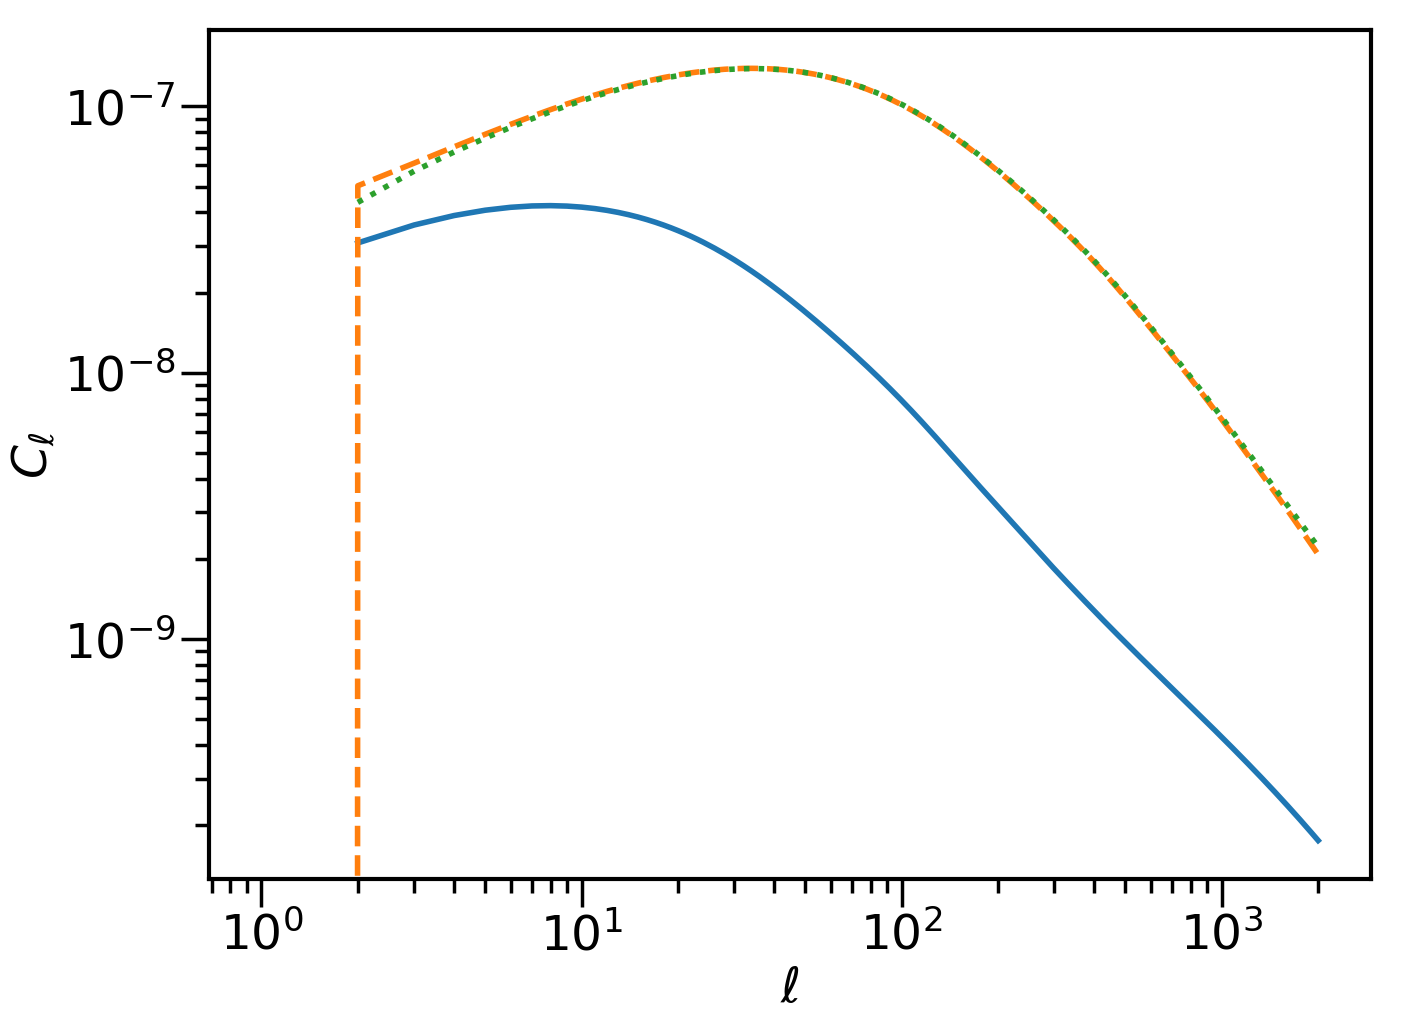

In [26]:
cl_t=cl0['cl0']#[(0,0)]
plot(np.arange(len(cl_t))+2,cl_t)
plot(np.arange(2001), camb_cl[:,0],'--')
plot(cl2['l'],cl2['cl']/1.6,':')
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


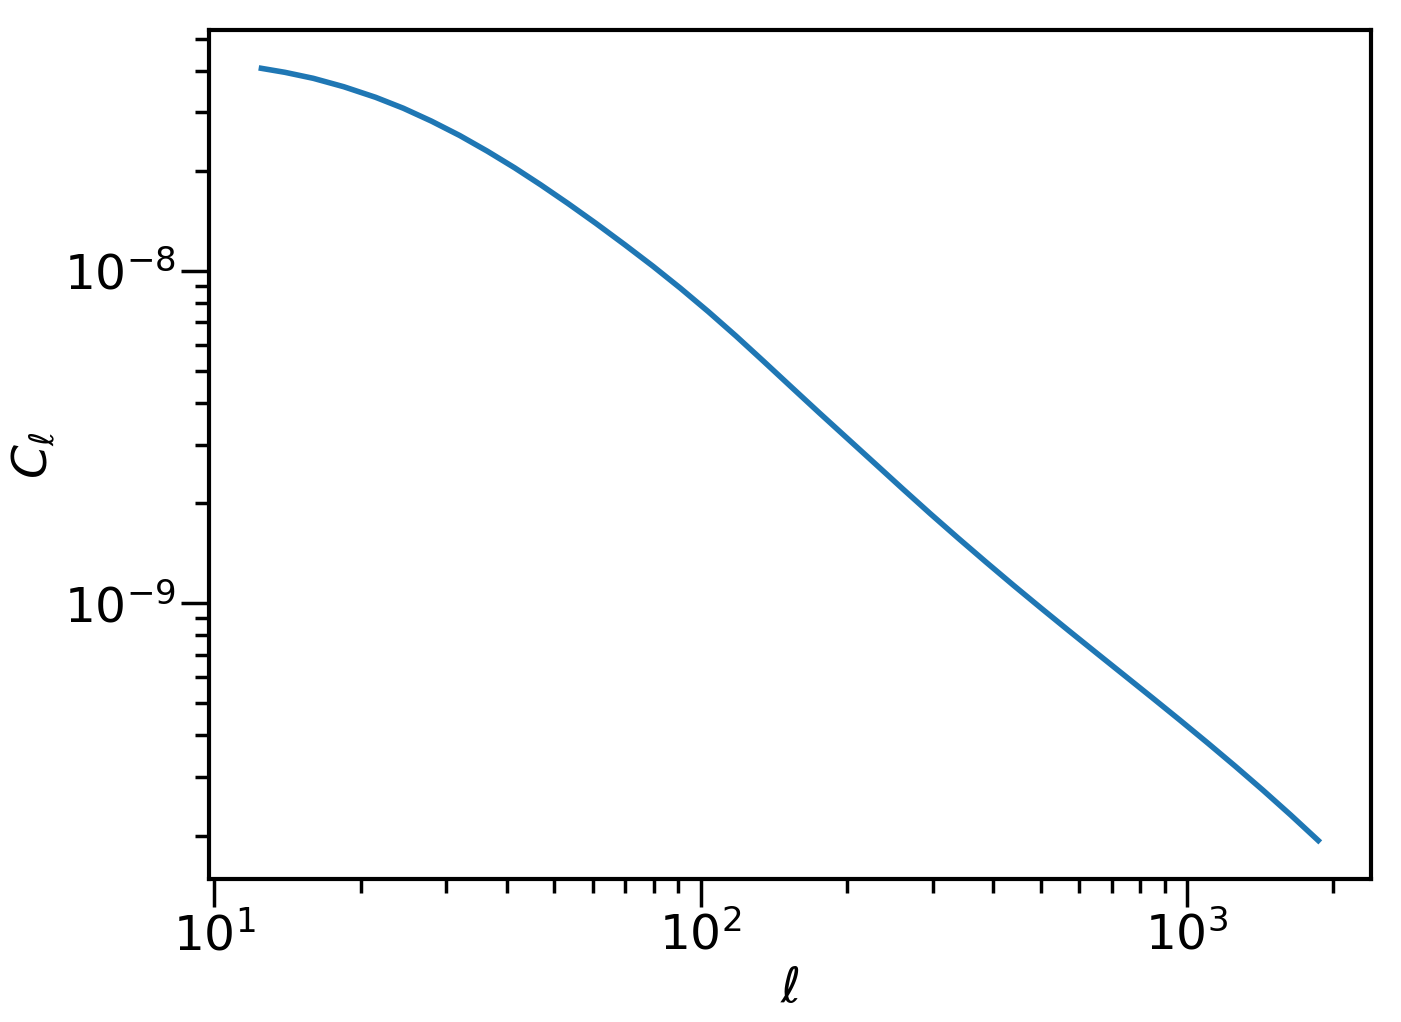

Text(0,0.5,'$C_\\ell$ Ratio')

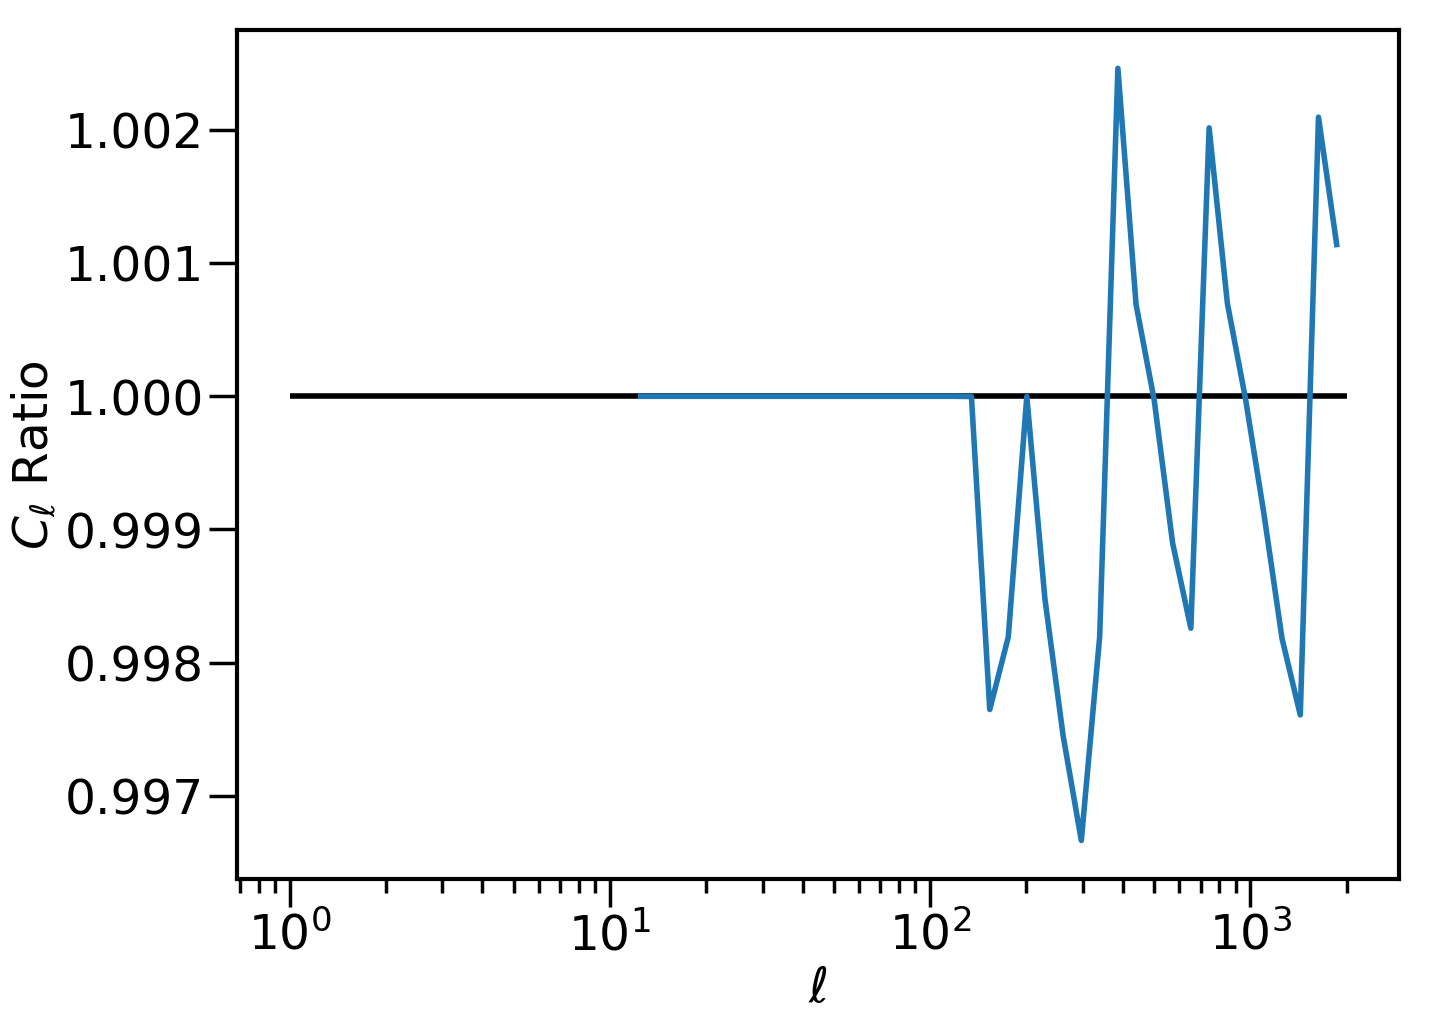

In [27]:
cl_t=cl0['cl']#[(0,0)]
cl_t2=cl1['cl']#[(0,0)]
plot(lb,cl_t)
# hlines(1,1,2000)
xscale('log')
yscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$')

show()
plot(lb,cl_t/cl_t2)
hlines(1,1,2000)
xscale('log')
xlabel('$\ell$')
ylabel('$C_\ell$ Ratio')
# ylim(8e-7,8.6e-7)
# yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


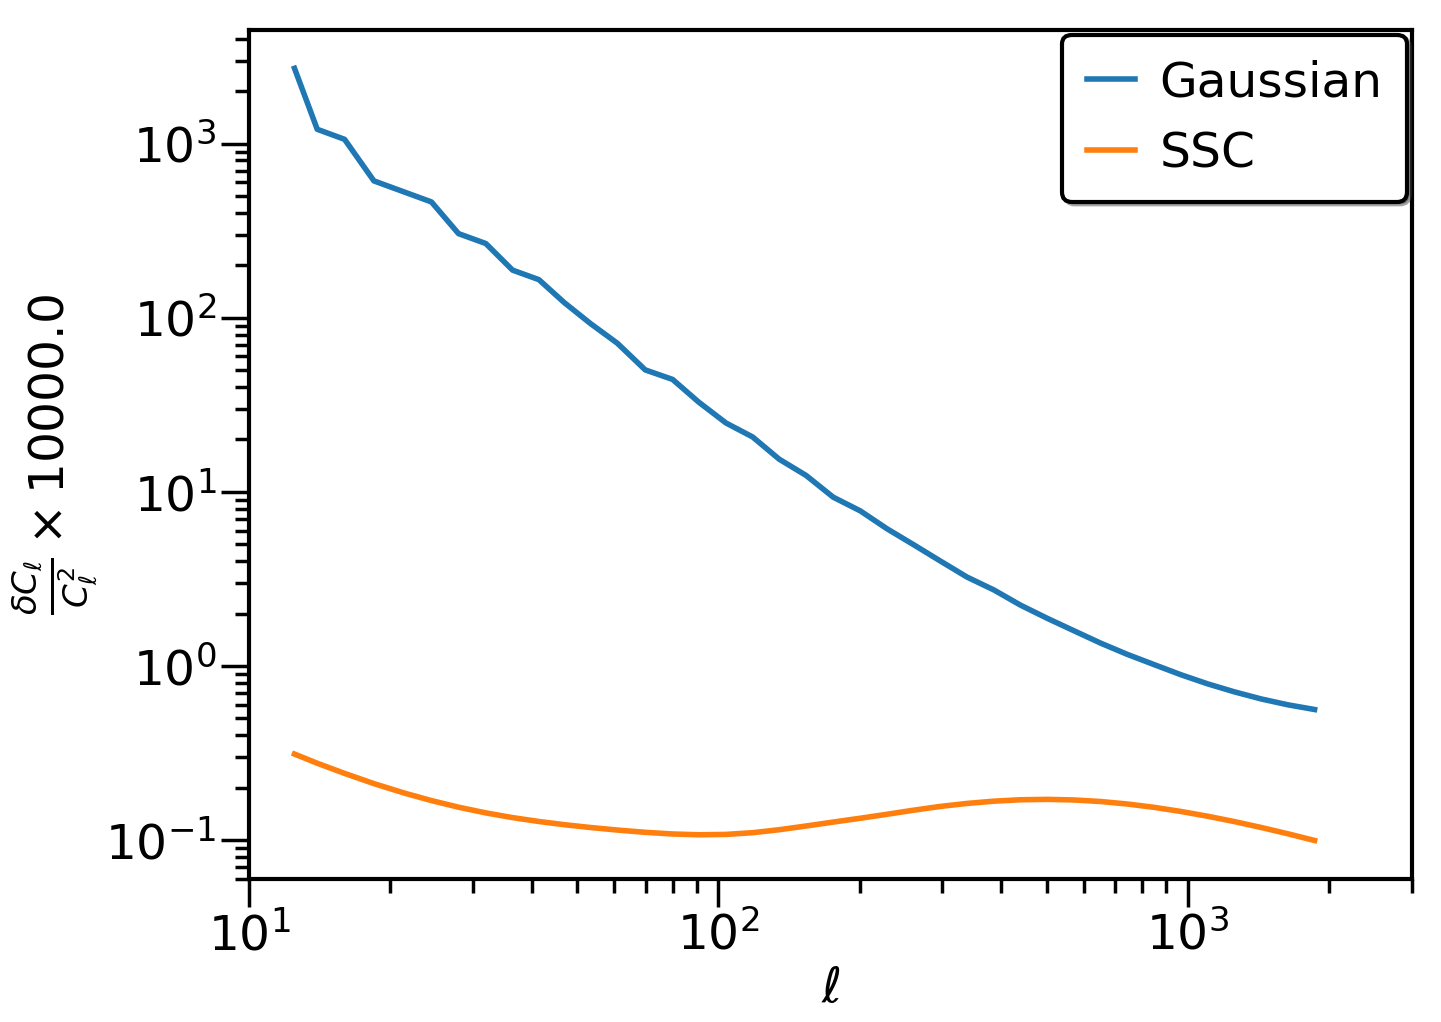

In [28]:
cov0=cl0['cov']#[(0,0,0,0)]
f=1e4
plot(lb,np.diag(cov0['G'])/cl_t**2*f,label='Gaussian')
#plot(lb,np.diag(cov02['G'])/cl_t**2*f*0.95)
plot(lb,np.diag(cov0['SSC'])/cl_t**2*f,label='SSC')
# plot(lb,np.diag(cov0['SSC_dk'])/cl_t**2*f)
xscale('log')
yscale('log')
xlim(10,3000)
xlabel(r'$\ell$')
ylabel(r'$\frac{\delta C_\ell}{C_\ell^2}\times'+str(f)+'$')
legend()

Text(0,0.5,'$\\ell$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


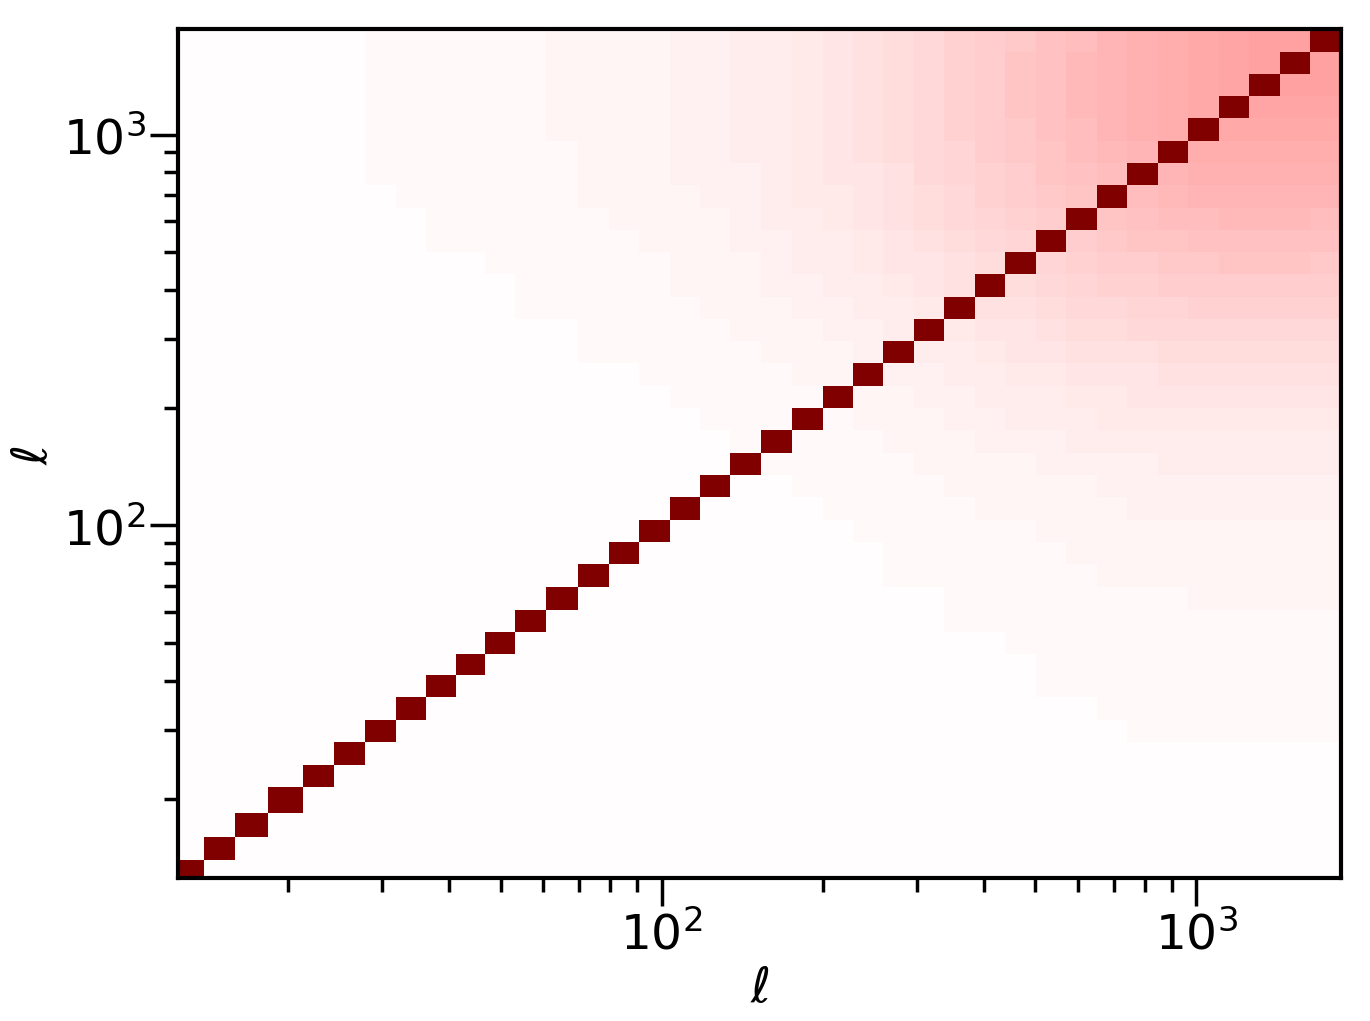

In [29]:
cov0=cl0['cov']#[(0,0,0,0)]
corr2=kappa0.cov_utils.corr_matrix(cov0['final'])
pcolor(lb,lb,corr2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
# xlim(lmin_clB,lmax_clB)
# ylim(lmin_clB,lmax_clB)
xlabel(r'$\ell$')
ylabel(r'$\ell$')

##  Test with multiple redshift bins (Tomography)

In [19]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26. #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))
zs_bins=zs_bin1
# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
bin_cl=True
SSV_cov=True
tidal_SSV=False
do_sample_variance=True
use_window=False

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [20]:
kappaS = cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=False,use_window=use_window,
                 do_sample_variance=do_sample_variance,z_PS_max=1.1,
               bin_xi=bin_xi)#ns=np.inf)

# kappaL = Kappa(zs_bins=zl_bins,l=l0,cross_PS=False,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,
#                stack_data=stack_data,SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [21]:
%time clSG=kappaS.cl_tomo()
kappaS.SN,kappa0.SN

[('shear', 'shear')]
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
CPU times: user 19.2 s, sys: 26.9 ms, total: 19.2 s
Wall time: 2.7 s


({('shear', 'shear'): array([[[2.92901365e-10]]])},
 {('shear', 'shear'): array([[[2.92901365e-10]]])})

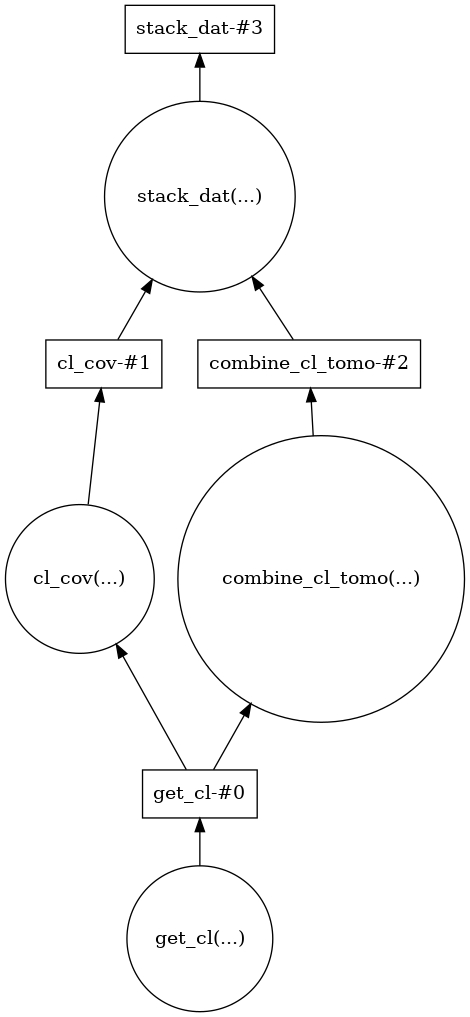

In [22]:
clSG['stack'].visualize() #compute graph

In [23]:
%time clS=clSG['stack'].compute()

1 39 1
CPU times: user 499 ms, sys: 9.99 ms, total: 509 ms
Wall time: 507 ms


In [24]:
# np.diag(kappaL.lensing_utils.SN[0]),
np.diag(kappaS.lensing_utils.SN[0])

array([2.92901365e-10])

In [25]:
covS_inv=np.linalg.inv(clS['cov'])
print (np.sqrt(np.dot(clS['cl'],np.dot(covS_inv,clS['cl']))))


417.18130864213083


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


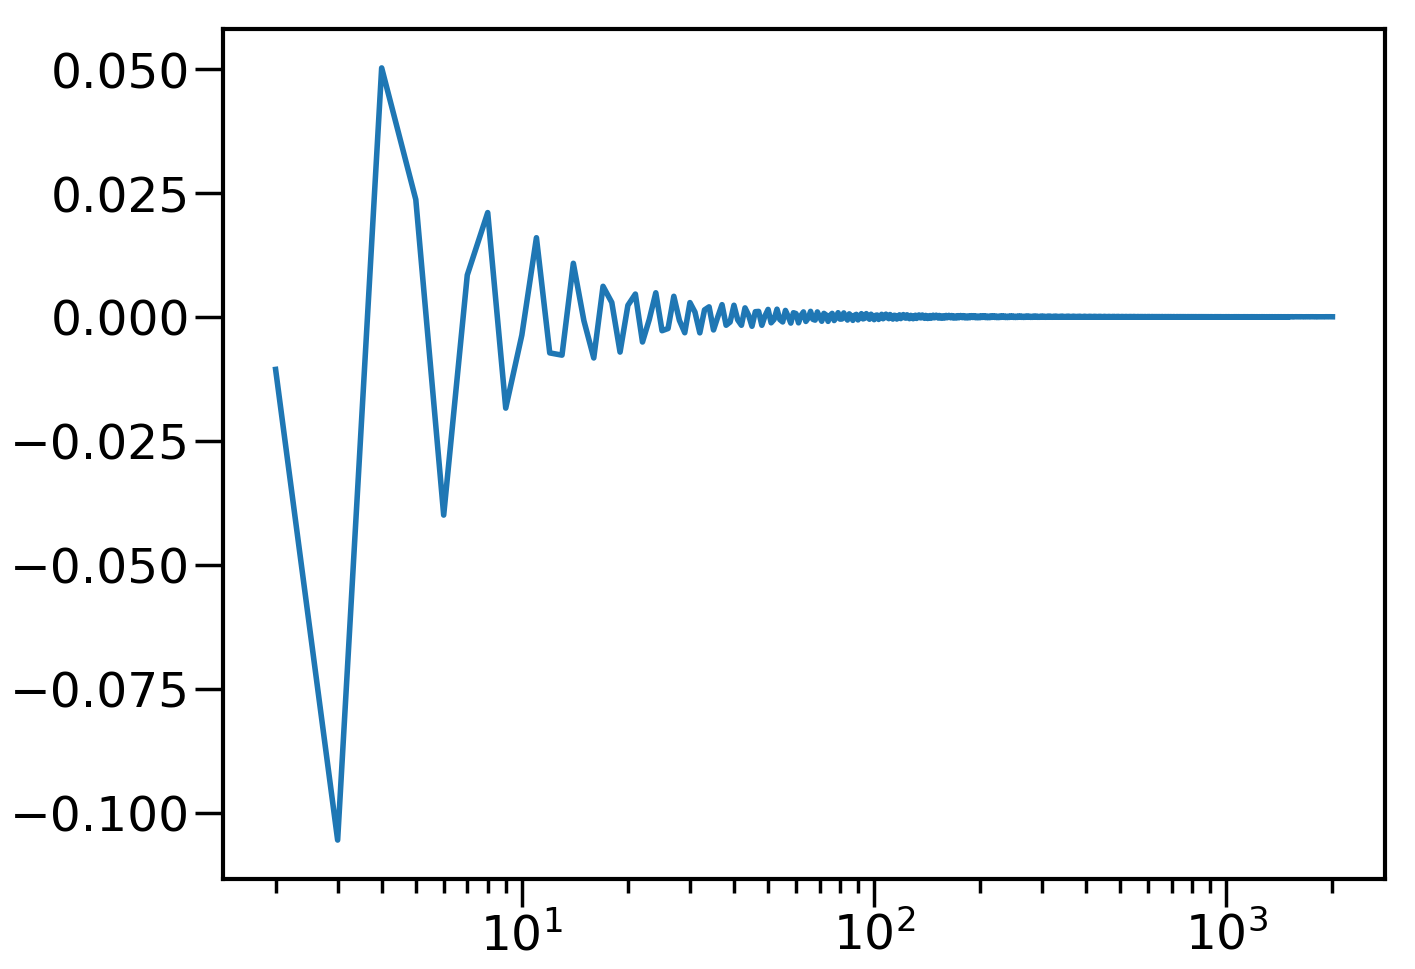

In [127]:
plot(kappaS.l,kappaS.cov_utils.Win)
xscale('log')

Text(0,0.5,'$p(z)$')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


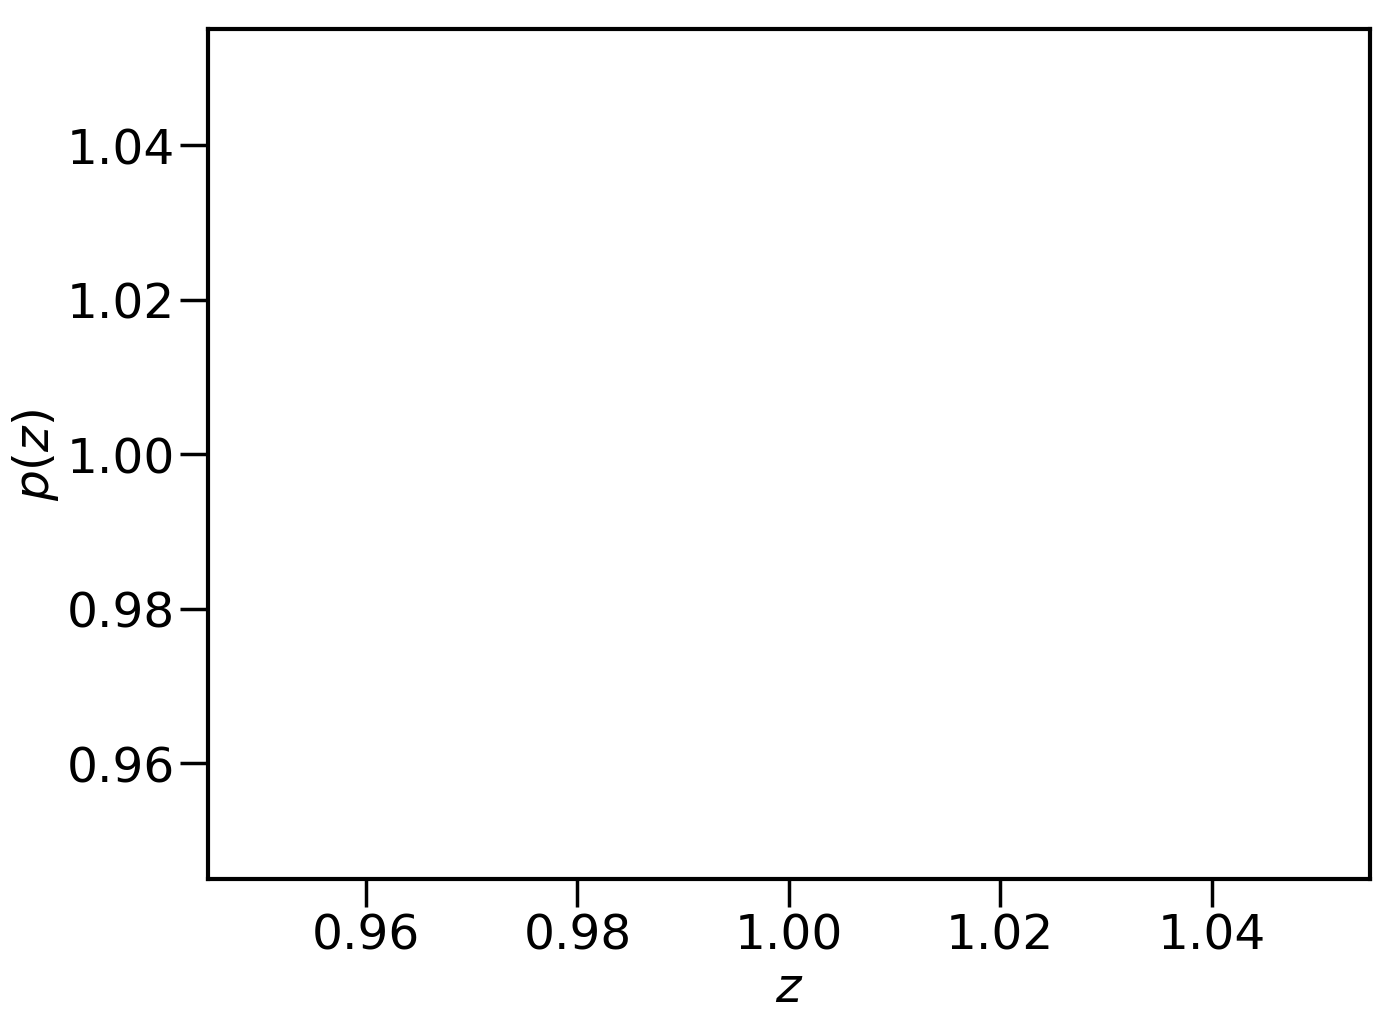

In [57]:
nb=kappaS.z_bins['shear']['n_bins']
for i in np.arange(nb):
    zb=zs_bins[i] #kappaS.zs_bins[i]
    plot(zb['z'],zb['pz'])
#     print(np.sum(zb['nz']))
xlabel(r'$z$')
ylabel(r'$p(z)$')

Text(0,0.5,'Lensing Kernel')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


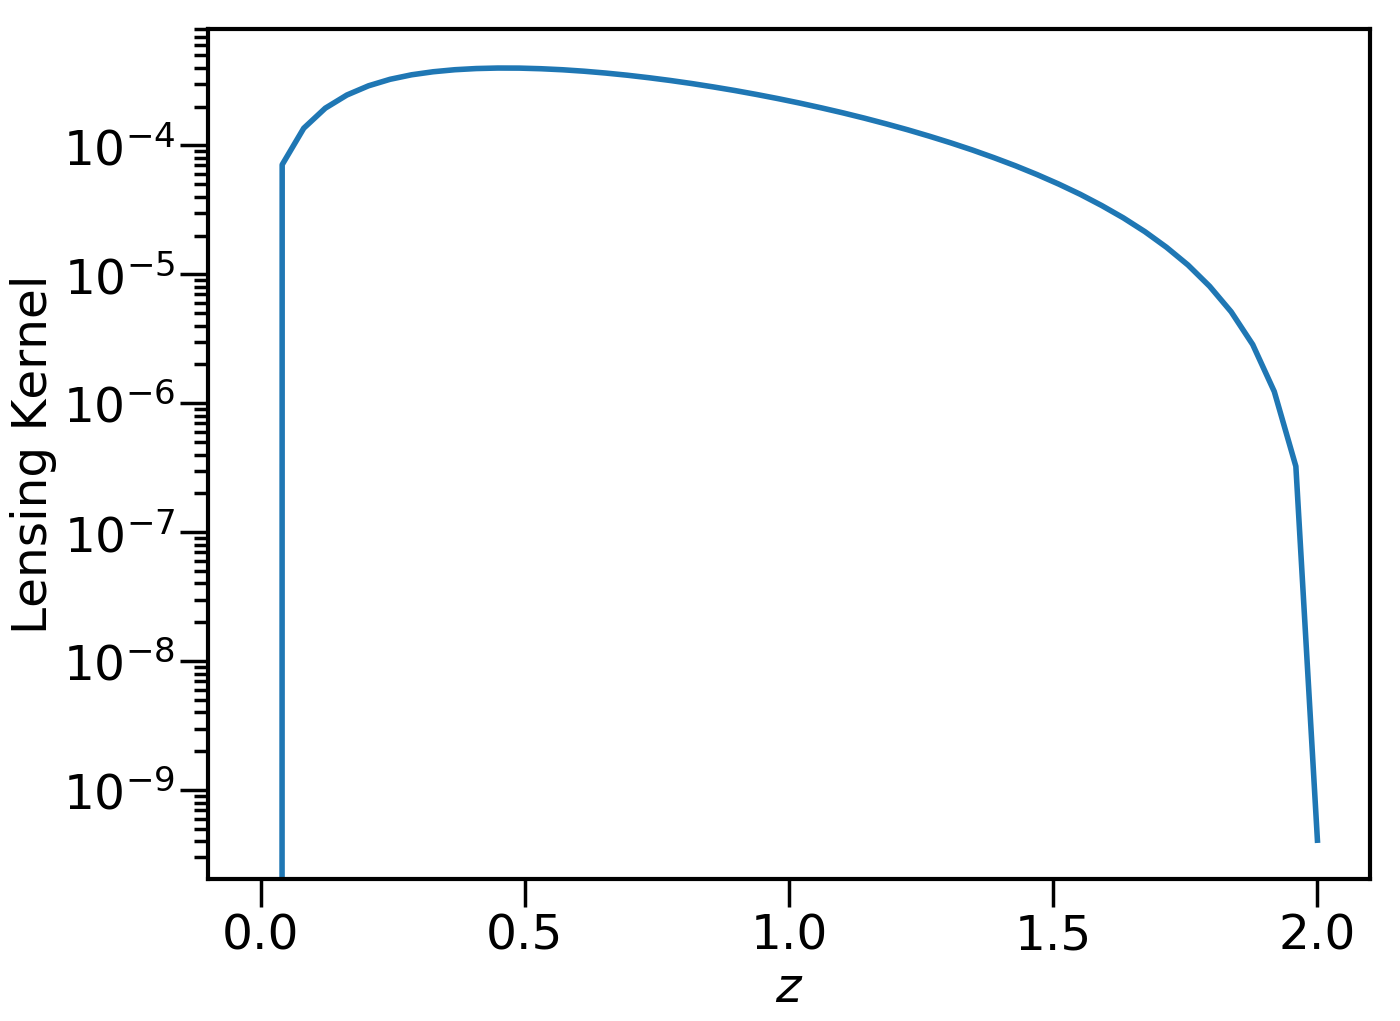

In [37]:
nb=kappaS.z_bins['shear']['n_bins']
zl=kappaS.z_bins['shear']['z_lens_kernel']
for i in np.arange(nb):
    zb=kappaS.z_bins['shear'][i]
    plot(zl,zb['lens_kernel'])
#     print(np.sum(zb['nz']))
#     print(zb['z'],zb['pz'])
yscale('log')
xlabel(r'$z$')
ylabel(r'Lensing Kernel')
# ylim(2.e-4,20)

In [92]:
clS['cov']/cl0['cov']['final']

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[1.0006378 ,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 1.00063557,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 1.0006321 , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 1.00112598,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan, 1.00102   ,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
        1.00091854]])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


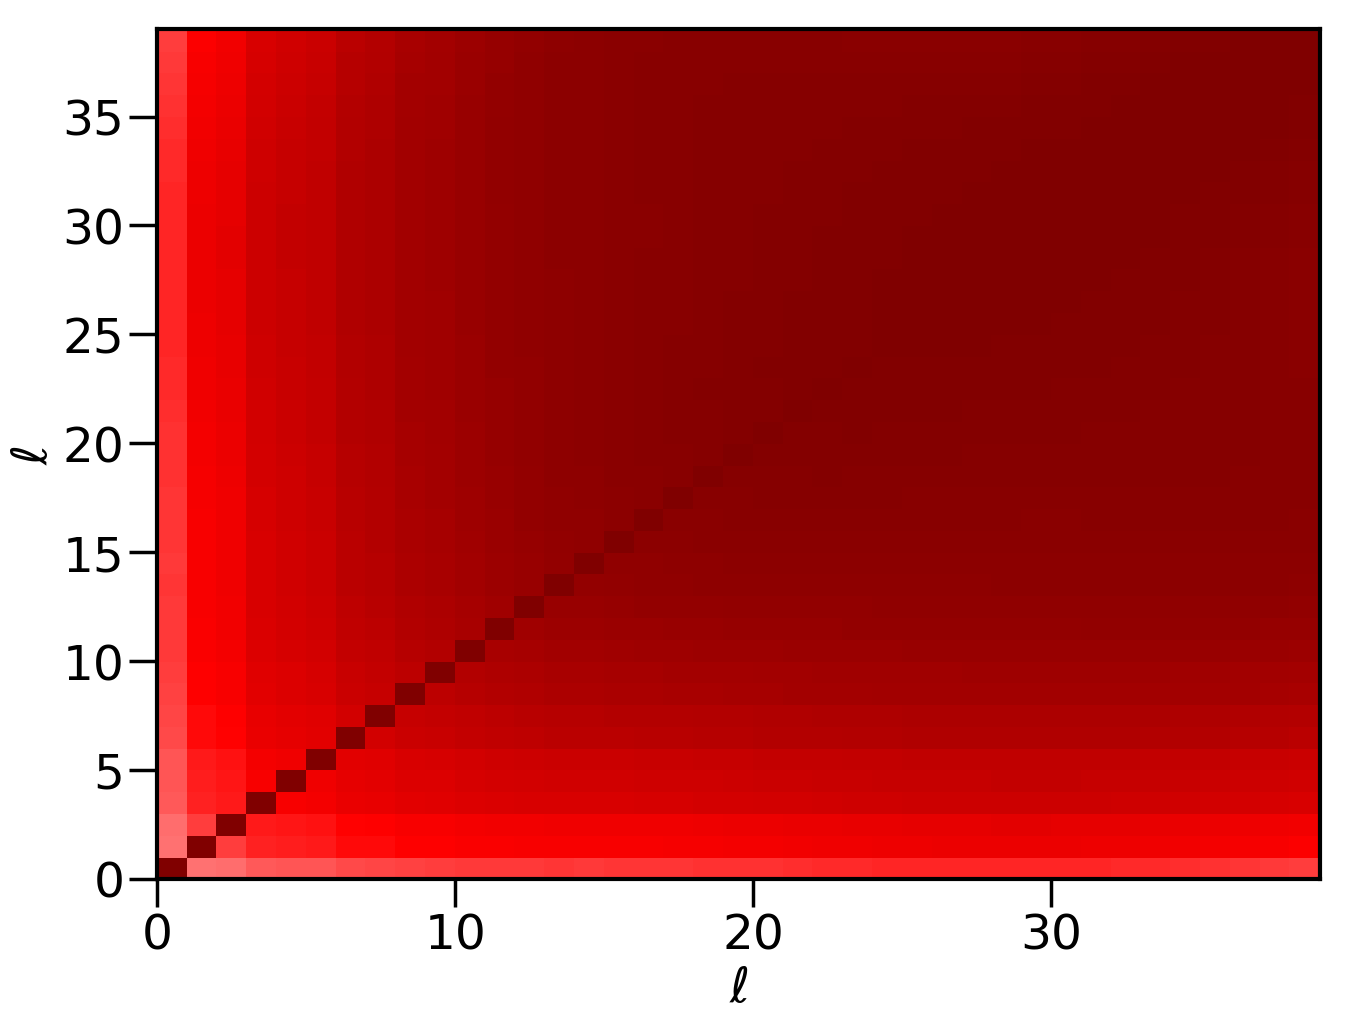

In [39]:
cc=kappaS.cov_utils
corrS=cc.corr_matrix(clS['cov'])
pcolor(corrS,vmin=-1,vmax=1,cmap='seismic')
xlabel(r'$\ell$')
ylabel(r'$\ell$')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [297]:
corr=('shear','shear')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


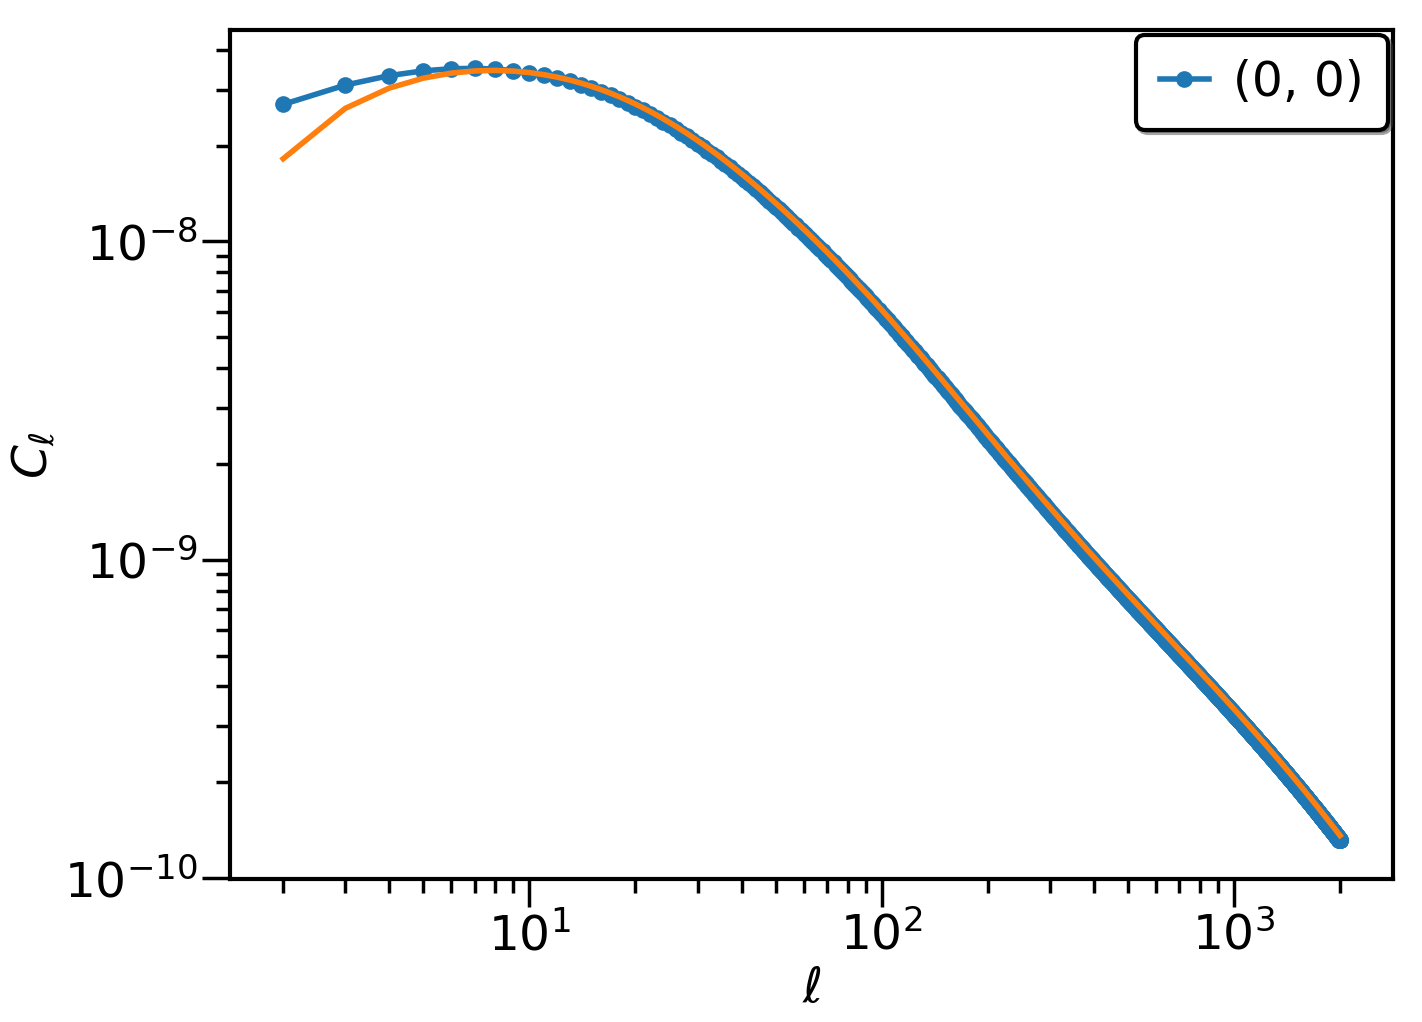

In [298]:
ell = np.arange(2, 2000)
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'])
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(lb,clSG['cl_b'][corr][(i,j)].compute(),np.sqrt(np.diag(clSG['cov'][corr+corr][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
        plot(l0,clSG['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, ell)
        plot(ell,cls)
        xscale('log')
        yscale('log')
        xlabel(r'$\ell$')
        ylabel(r'$C_\ell$')
        legend()
        show()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


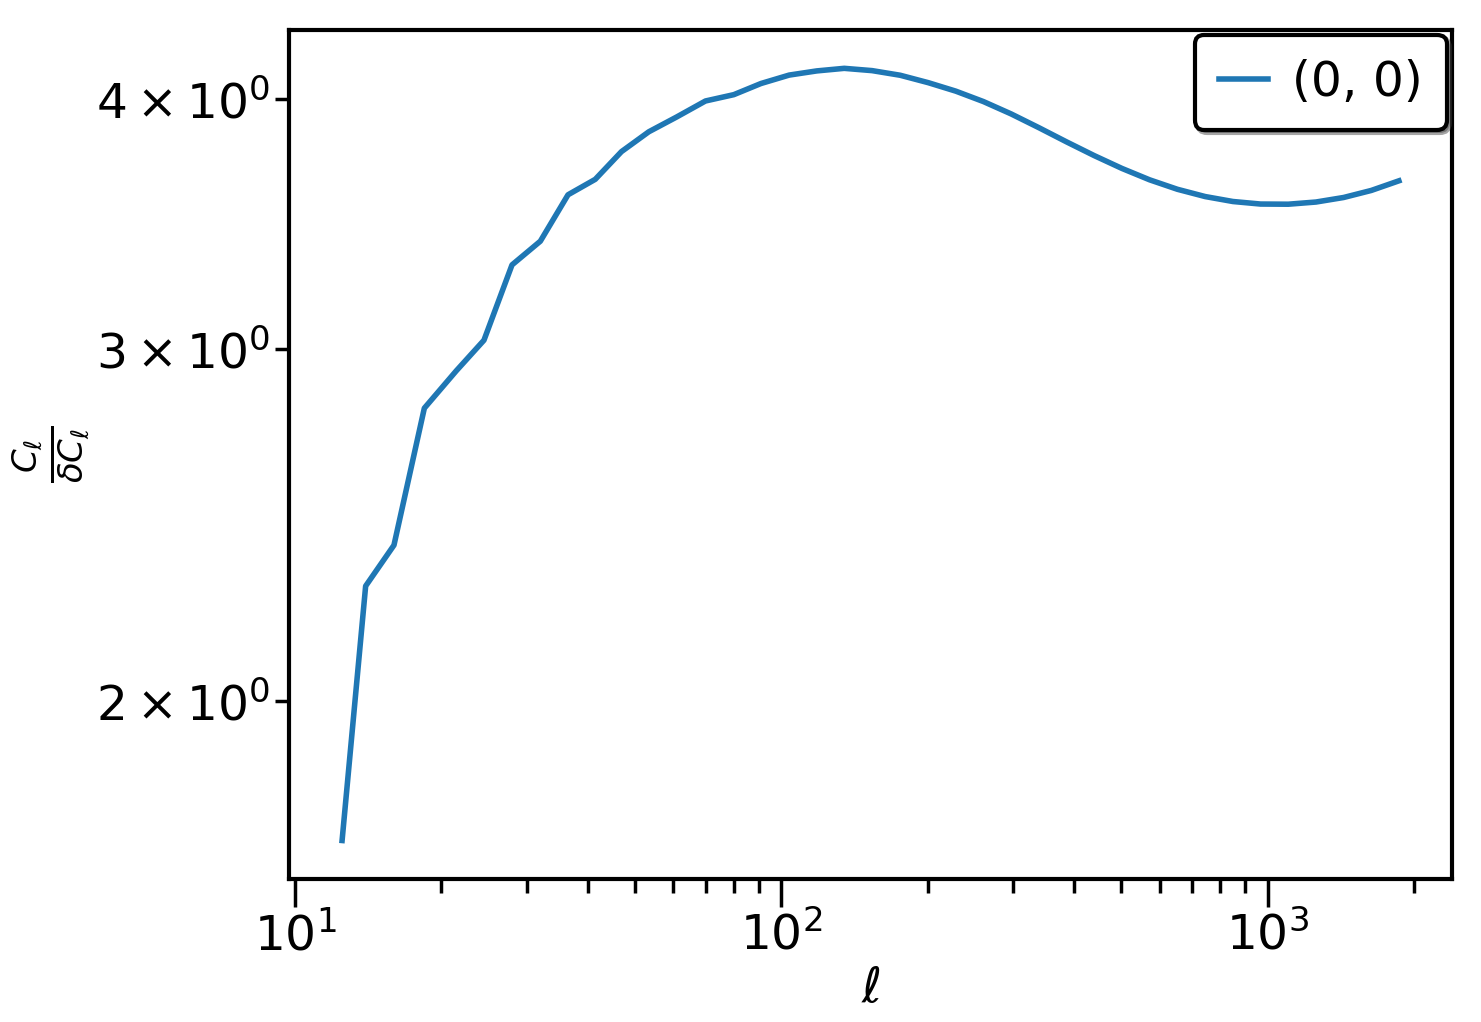

In [299]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(lb,clSG['cl_b'][corr][(i,j)].compute()/np.sqrt(np.diag(clSG['cov'][corr+corr][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\frac{C_\ell}{\delta C_\ell}$')
legend()

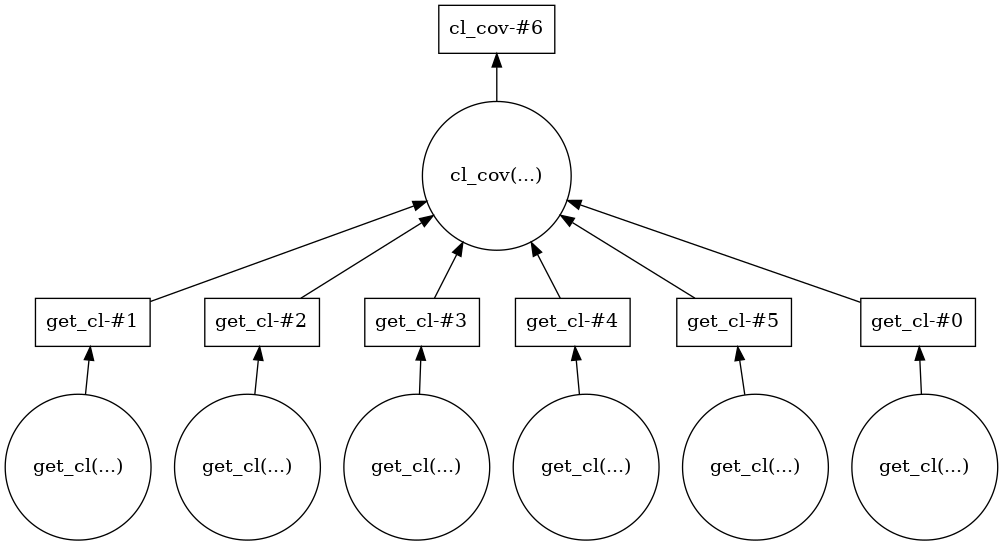

In [34]:
clSG['cov'][corr+corr][(0,0,0,0)].visualize() #graph for 1 covariance

# Lensing X Lensing Correlation function covariance

##  Test with multiple redshift bins (Tomography)

In [8]:
from importlib import reload
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [10]:
import hankel_transform
reload(hankel_transform)
from hankel_transform import *

In [11]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=3  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

do_cov=True
SSV_cov=False
tidal_SSV=False

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [12]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999633

In [13]:
do_xi=True
bin_xi=True
bin_cl=False
th_min=1./60
th_max=10
n_th_bins=10
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins*10)
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [14]:
#Hankel Transform setup
l_max=1e4
l_min=2
prune_theta=2
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [15]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999633

In [16]:
bin_xi=True

In [17]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
l0=l_W
l_bins=None
WT_kwargs={'l':l_W ,'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
# if not 'WT' in globals():
%time WT=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 169 ms, sys: 292 ms, total: 460 ms
Wall time: 6.37 s


In [18]:
# Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': np.arange(2,l_max*2,dtype='int'),'theta': th*d2r,'m1_m2':[(2,2),(2,-2)]}
# if (not 'WT_L' in globals()):
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=None,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

CPU times: user 272 ms, sys: 338 ms, total: 610 ms
Wall time: 7.26 s


In [29]:
%time clHG=XI_H.cl_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time clWG=XI_W.cl_tomo()
%time clWG_L=XI_W_L.cl_tomo()

[('shear', 'shear')]
CPU times: user 14.5 s, sys: 90.5 ms, total: 14.6 s
Wall time: 5.75 s
[('shear', 'shear')]
CPU times: user 14.6 s, sys: 63.1 ms, total: 14.6 s
Wall time: 5.74 s
[('shear', 'shear')]
CPU times: user 14.2 s, sys: 63.3 ms, total: 14.3 s
Wall time: 5.79 s


In [30]:
np.sum(zs_bins[0]['pzdz'])

0.9999999999999633

In [31]:
%time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()

%time xiWG=XI_W.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()

[('shear', 'shear')]
CPU times: user 36.4 ms, sys: 0 ns, total: 36.4 ms
Wall time: 35.4 ms
[('shear', 'shear')]
CPU times: user 20.3 ms, sys: 5 µs, total: 20.3 ms
Wall time: 20.2 ms
[('shear', 'shear')]
CPU times: user 21.1 ms, sys: 3.34 ms, total: 24.5 ms
Wall time: 22.2 ms


In [32]:
%time xiH=xiHG['stack'].compute()
# %time xiH2=xiHG2['stack'].compute()

12 10 2
CPU times: user 4min 10s, sys: 1.13 s, total: 4min 11s
Wall time: 20.7 s


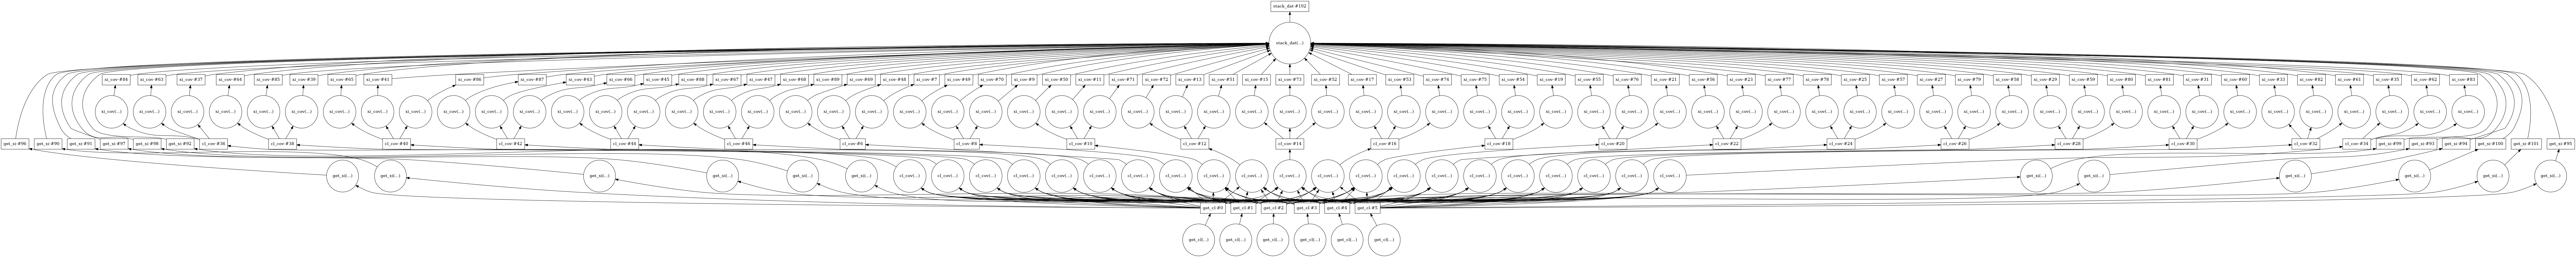

In [33]:
xiHG['stack'].visualize() #compute graph

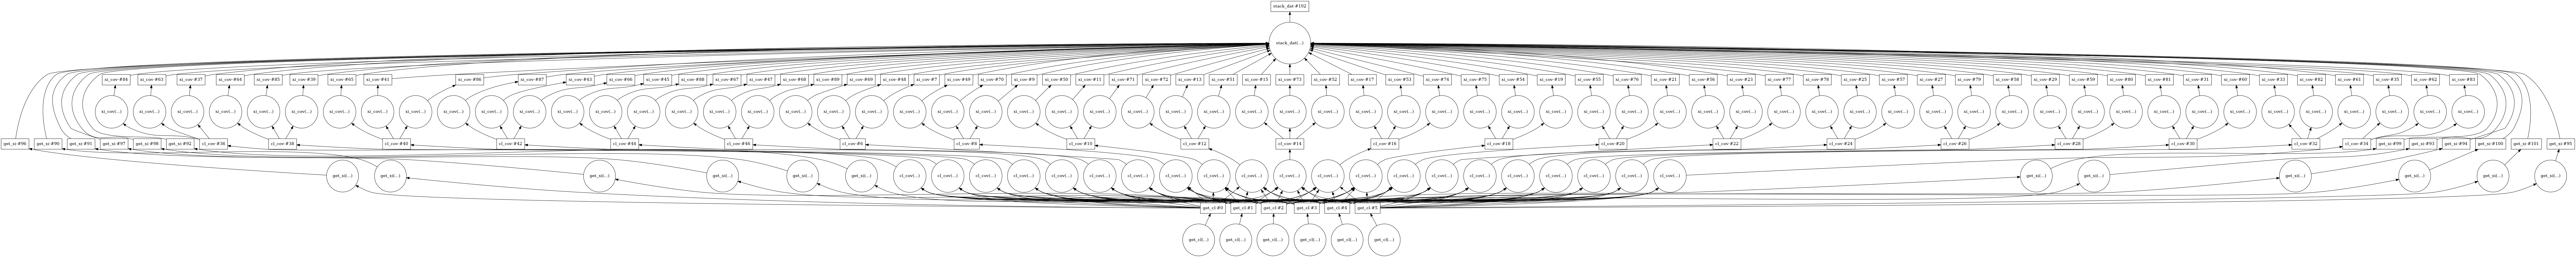

In [109]:
xiWG['stack'].visualize() #compute graph

In [34]:
%time xiW=xiWG['stack'].compute()
%time xiW_L=xiWG_L['stack'].compute()

12 10 2
CPU times: user 25.8 s, sys: 589 ms, total: 26.4 s
Wall time: 1.83 s
12 10 2
CPU times: user 53.7 s, sys: 1.14 s, total: 54.8 s
Wall time: 3.68 s


In [35]:
f=1
cov_xiH_inv=np.linalg.inv(xiH['cov']*f)
print (np.sqrt(np.dot(xiH['xi'],np.dot(cov_xiH_inv,xiH['xi']))))

cov_xiW_inv=np.linalg.inv(xiW['cov']*f)
print (np.sqrt(np.dot(xiW['xi'],np.dot(cov_xiW_inv,xiW['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print (np.sqrt(np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

552.0158926292698
496.944251609031
485.5499031158634


/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
05:27:43 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=42.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
05:27:43 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


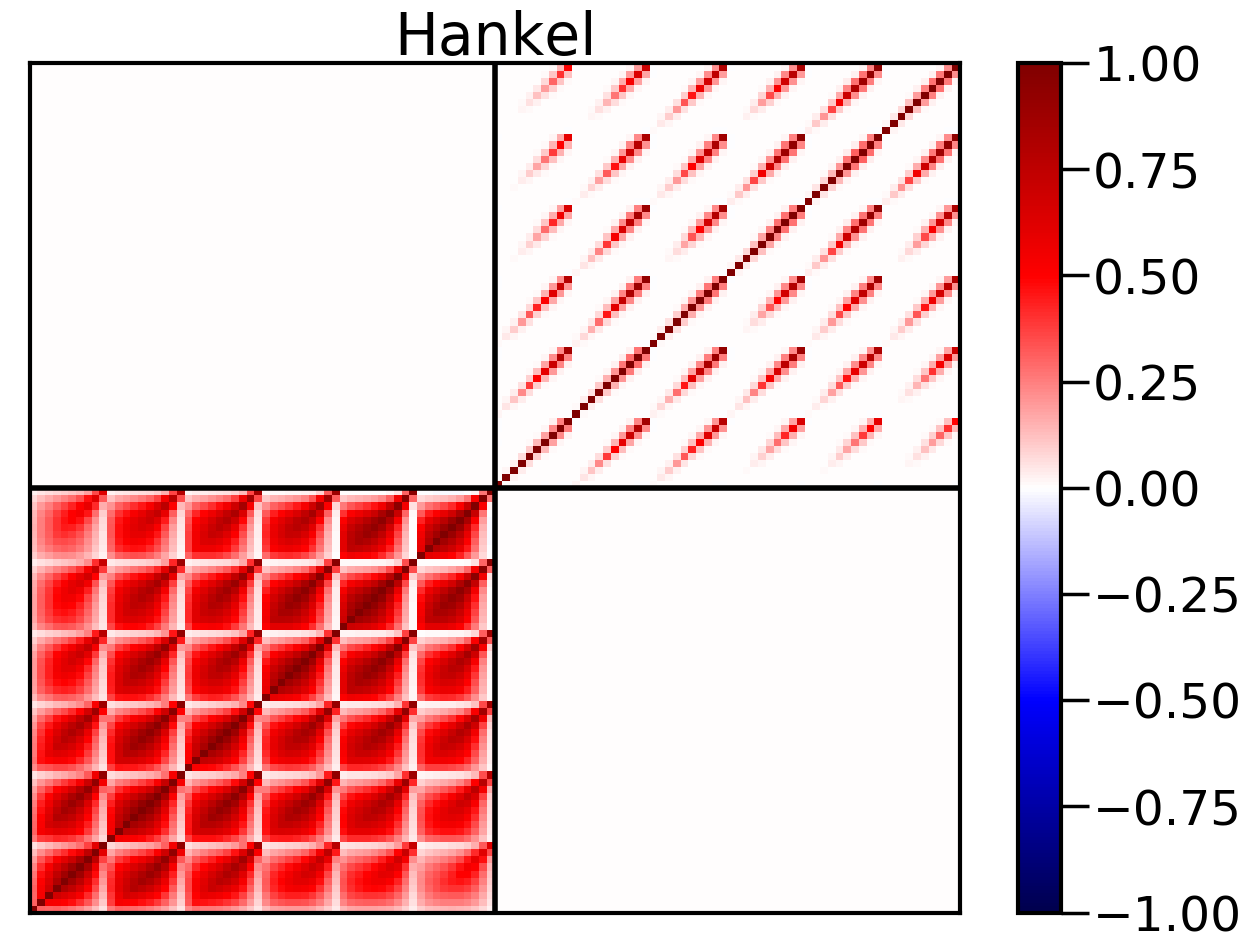

In [36]:
cc=XI_H.cov_utils
corrH=cc.corr_matrix(xiH['cov'])
pcolor(corrH,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Hankel')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


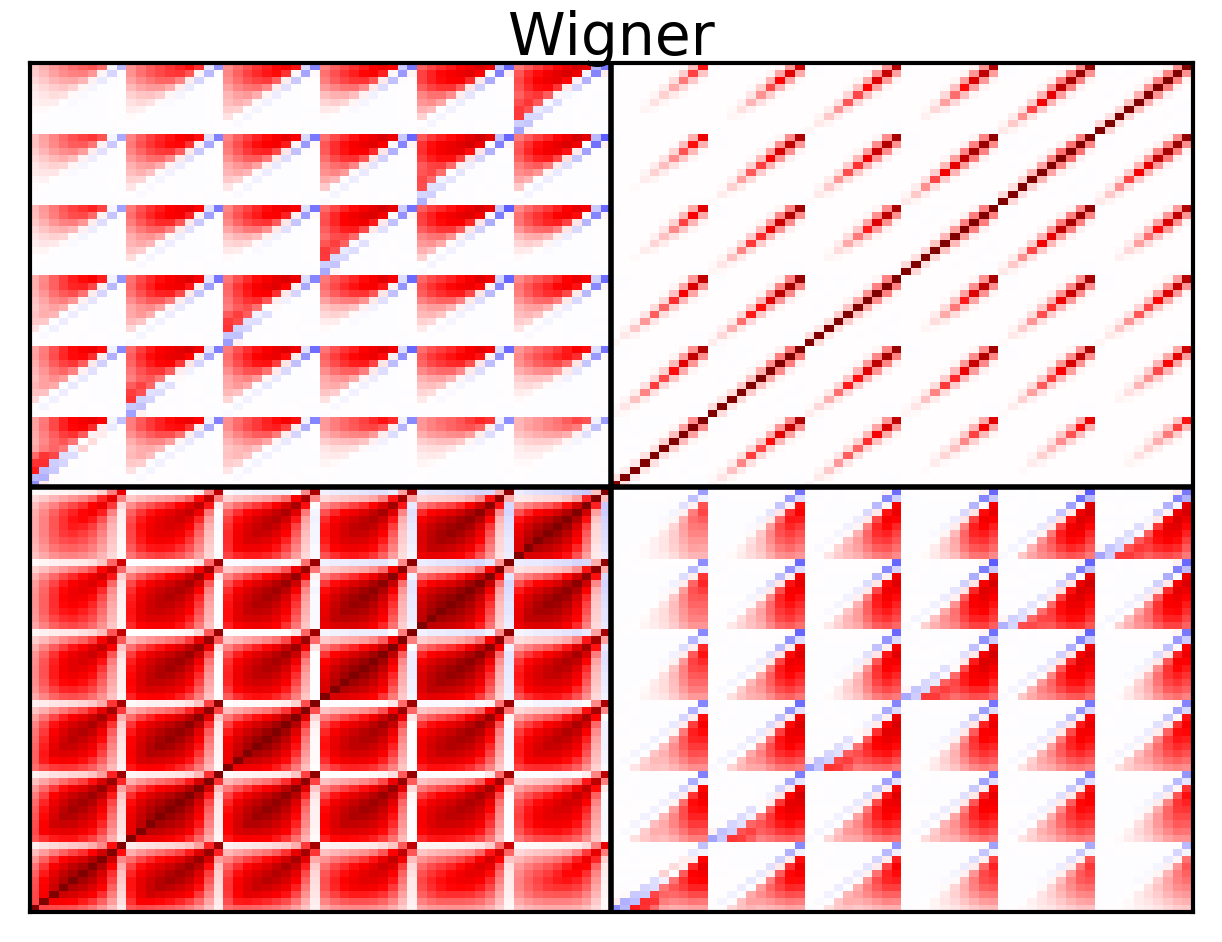

In [37]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
hlines(60,0,120)
vlines(60,0,120)
xticks([])
yticks([])
title('Wigner')
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


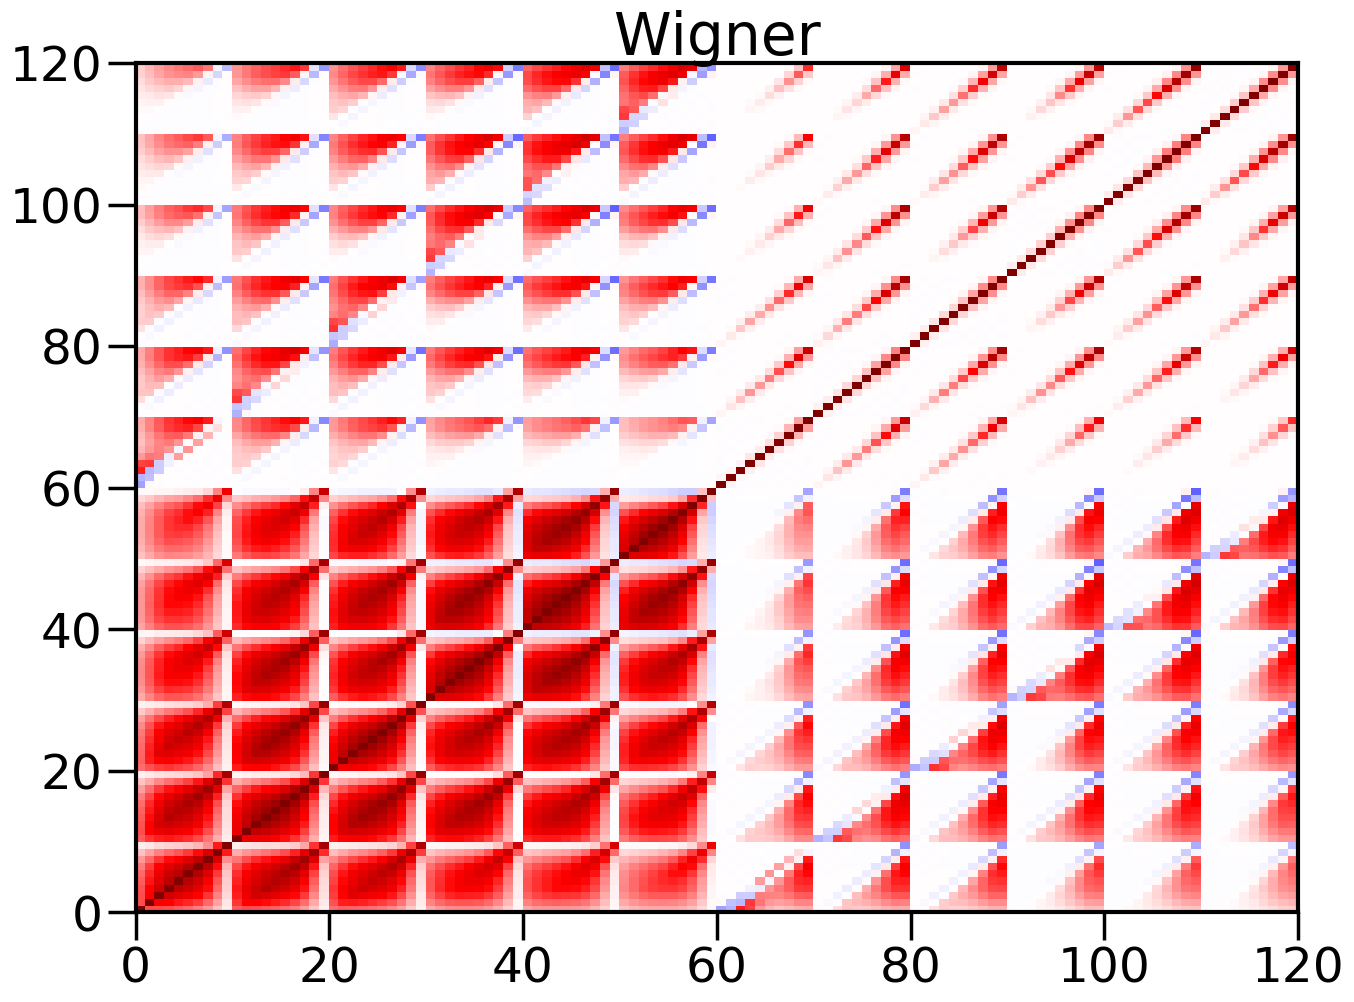

In [38]:
cc=XI_W.cov_utils
corrWL=cc.corr_matrix(xiW_L['cov'])
pcolor(corrWL,vmin=-1,vmax=1,cmap='seismic')
title('Wigner')
show()

In [39]:
corr=('shear','shear')

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


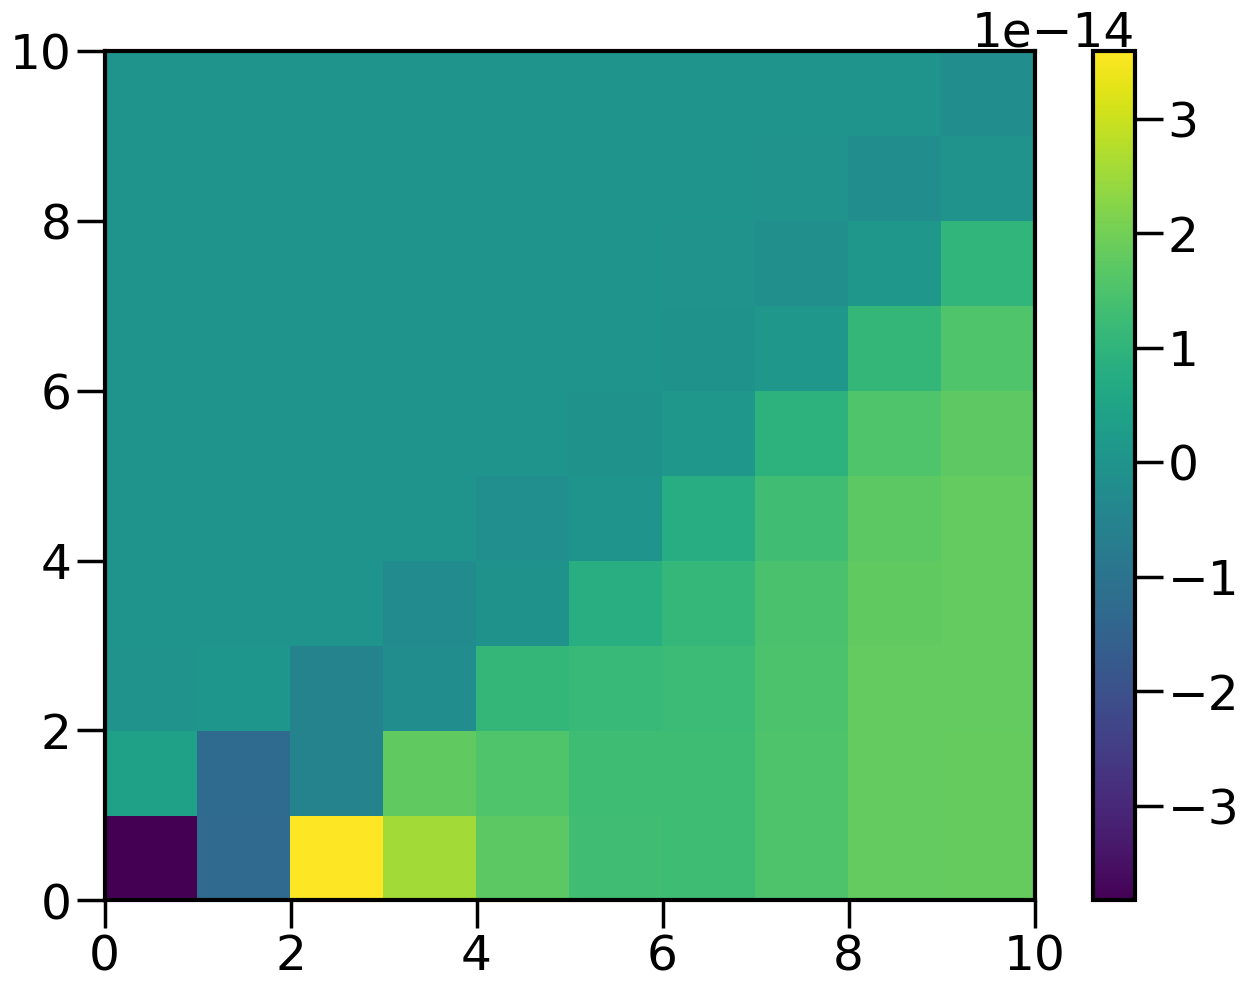

In [116]:
m1m2=(2, 2, 2, -2)
i=0
j=0
cov_t=xiWG['cov'][corr+corr][m1m2][(i,j,i,j)].compute()
pcolor(cov_t['final'])
colorbar()
# print (cov_t)

In [40]:
m1m2=(2,2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


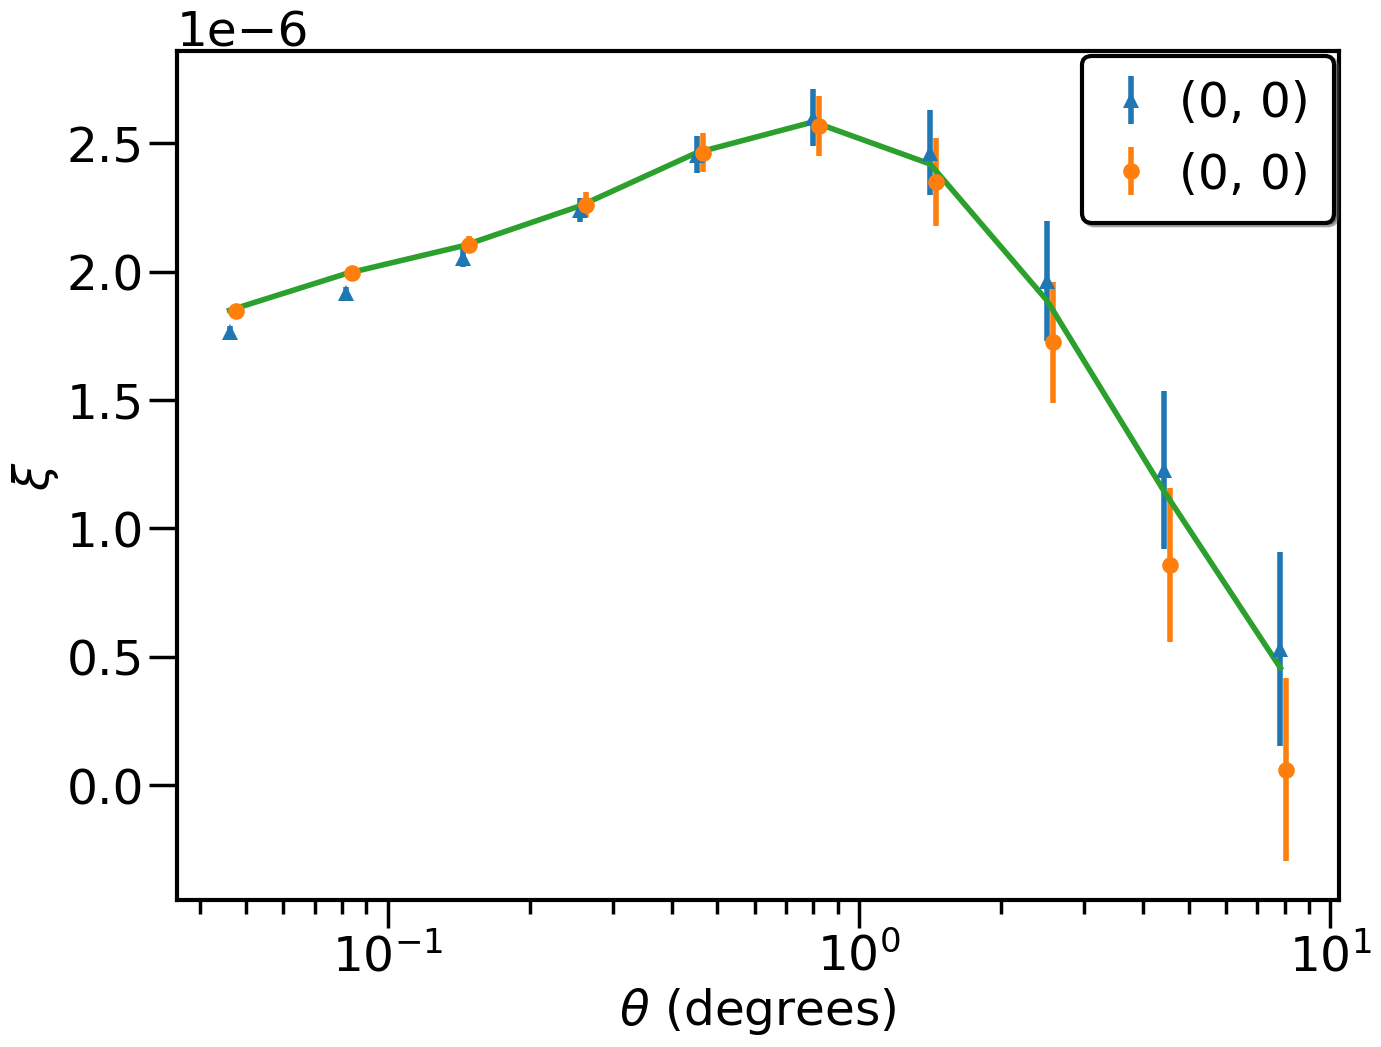

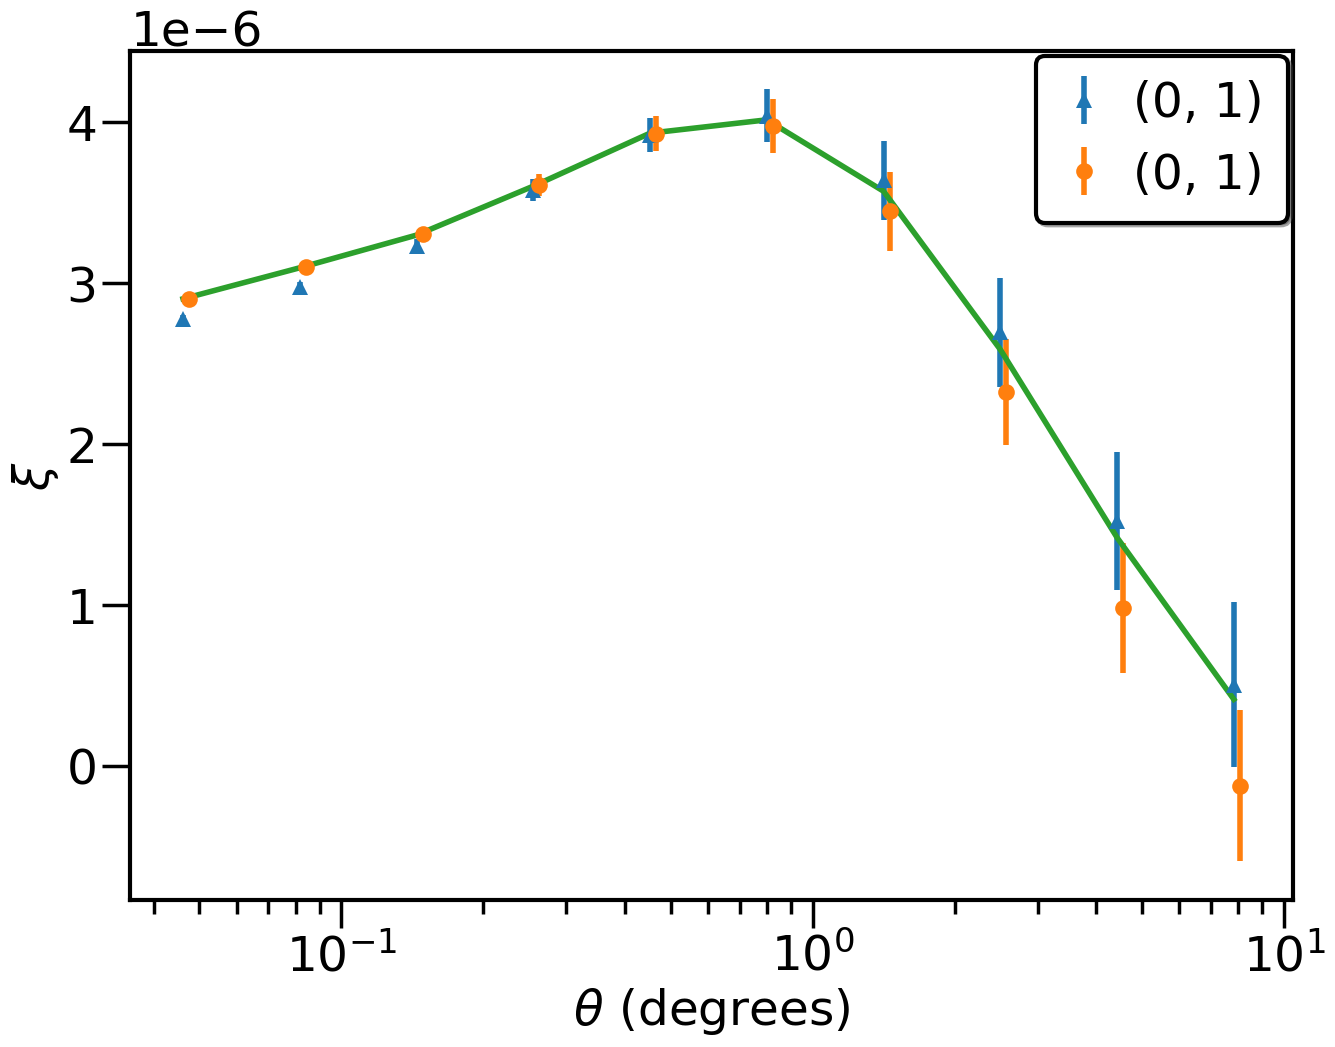

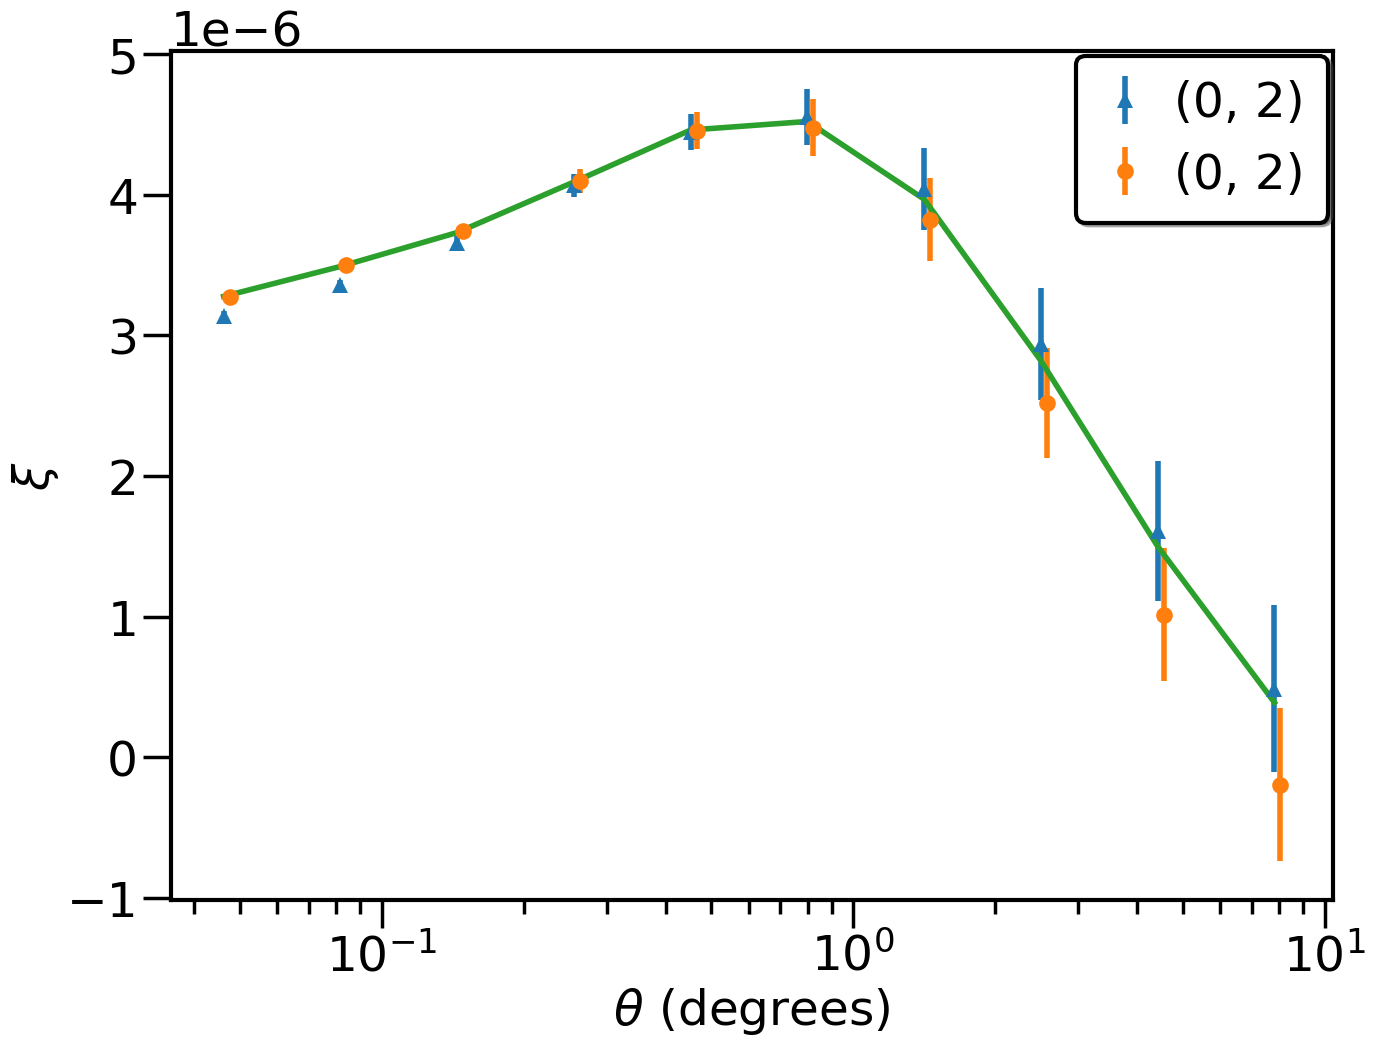

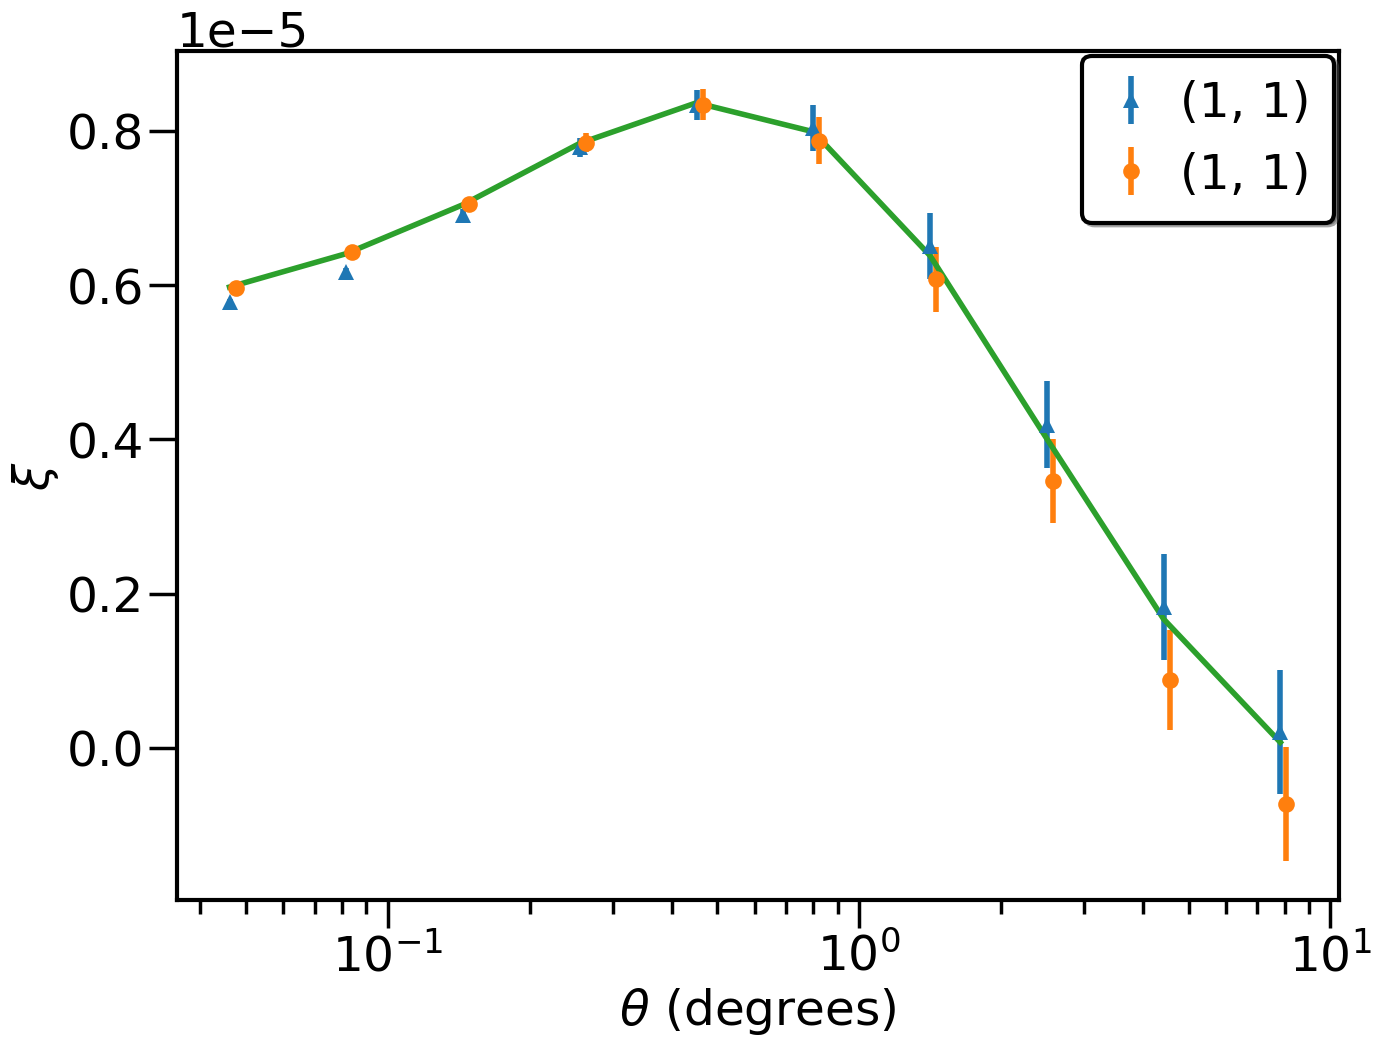

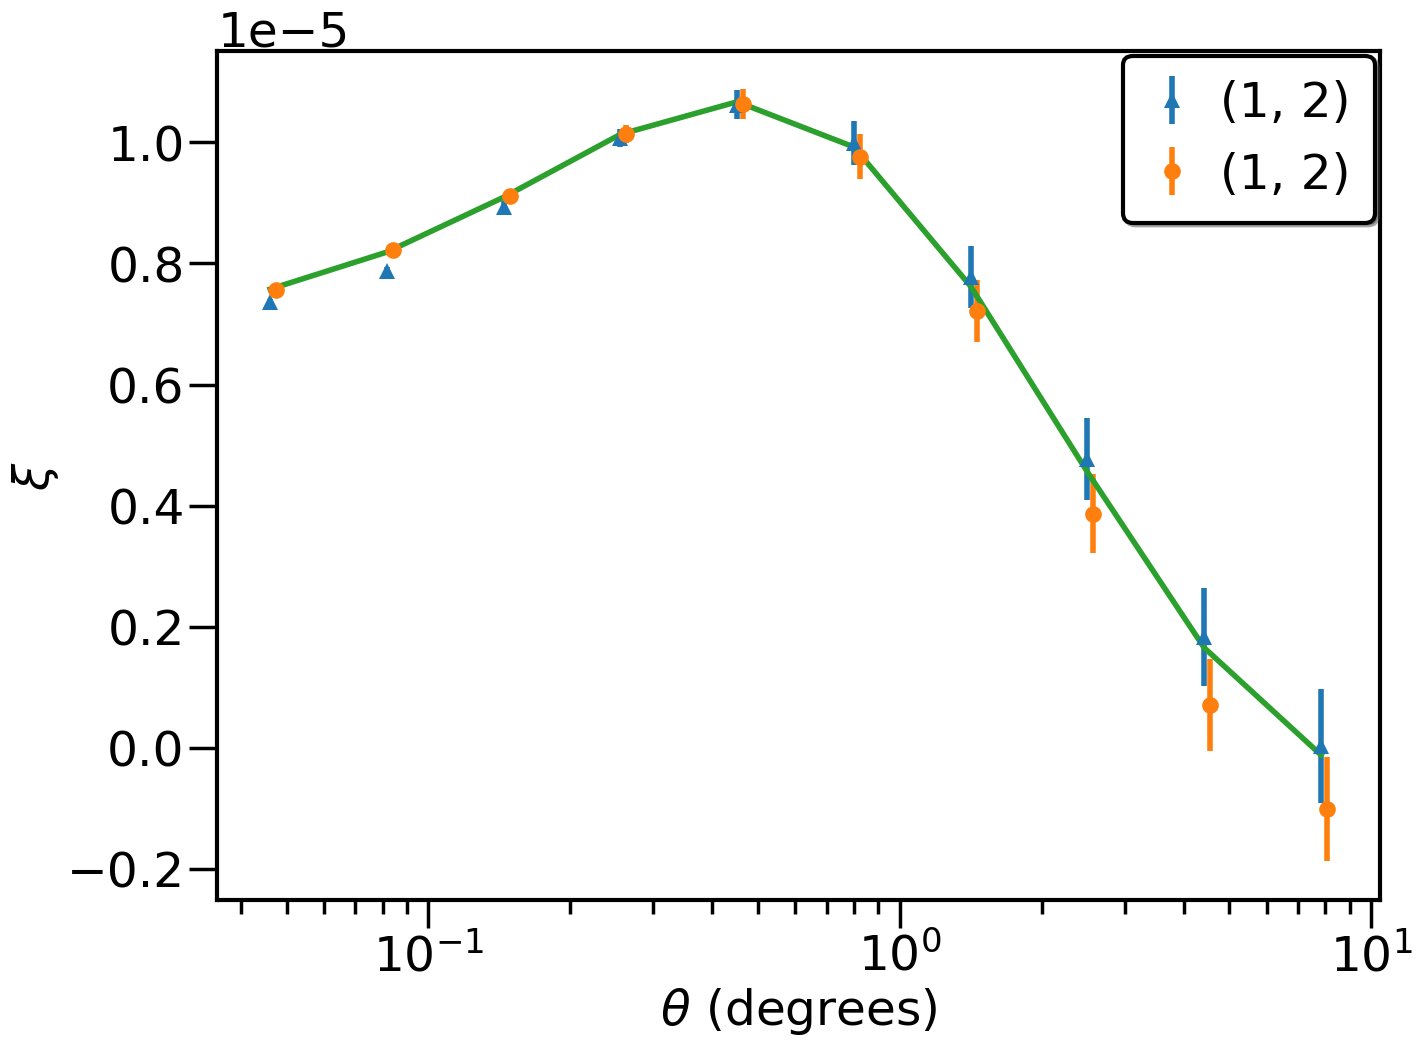

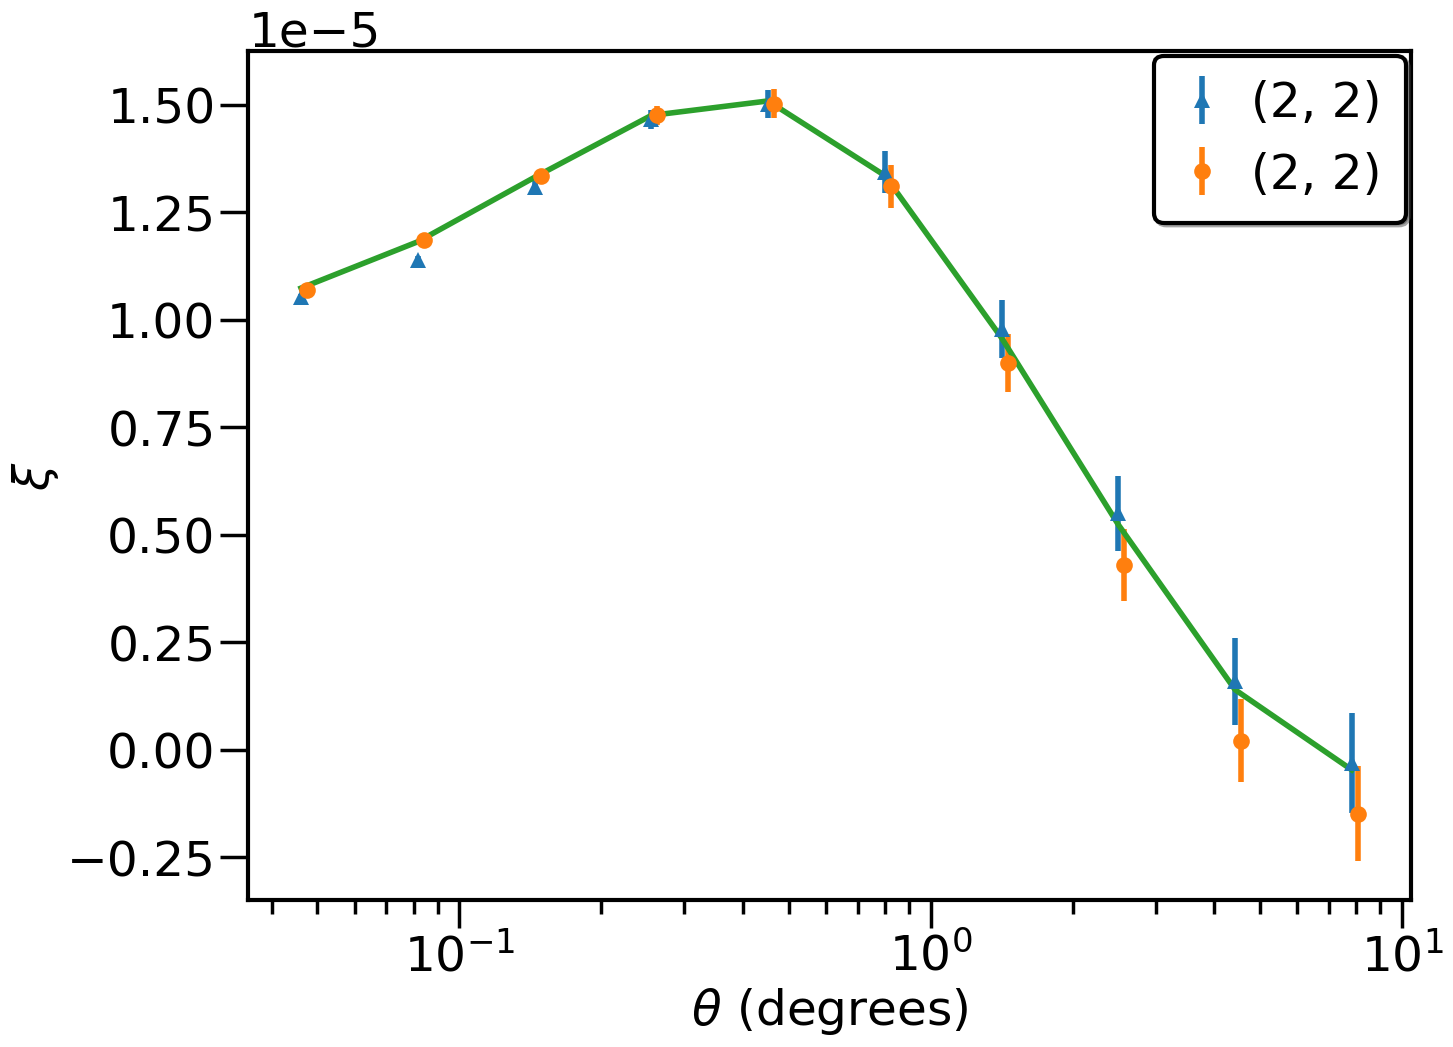

In [54]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb*1.0,thb*xiHG['xi'][corr][m1m2][(i,j)].compute(),thb*np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='^',label=(i,j))
        errorbar(thb*1.03,thb*xiWG_L['xi'][corr][m1m2][(i,j)].compute(),thb*np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
        xi_plus = ccl.correlation(ccl_cosmo, XI_W_L.l, cls, XI_W_L.HT.theta[m1m2]/d2r,corr_type='L+', method='FFTLog')
        xi_b=XI_W_L.binning.bin_1d(xi=xi_plus,bin_utils=XI_W_L.xi_bin_utils[m1m2])
        plot(thb,thb*xi_b)
        xscale('log')
#         yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
        show()

04:26:55 WARNING:No handles with labels found to put in legend.
/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


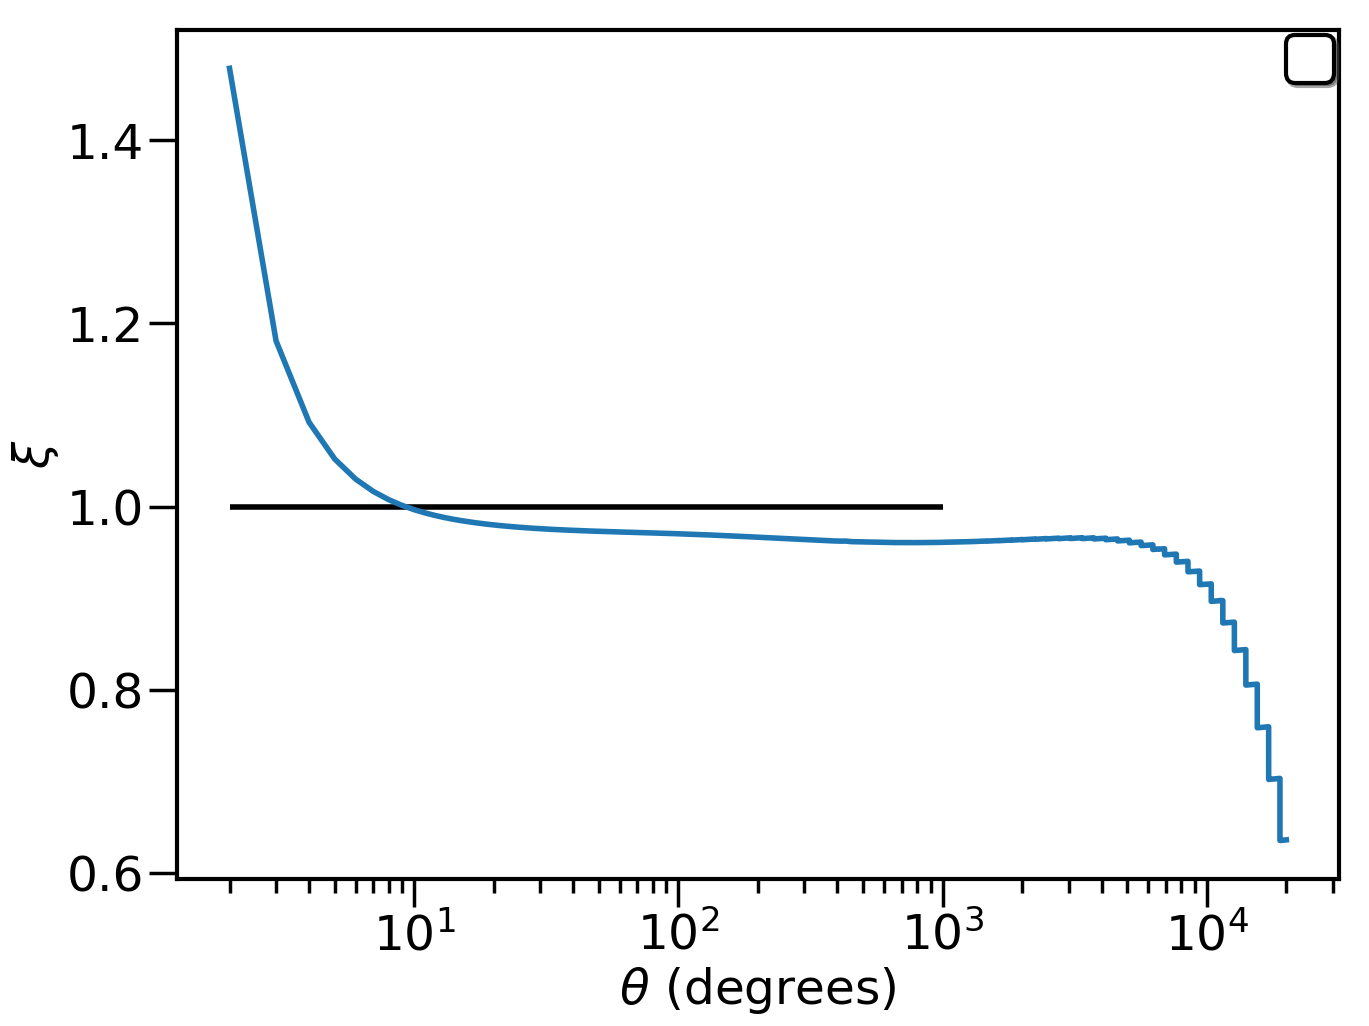

04:26:55 WARNING:No handles with labels found to put in legend.


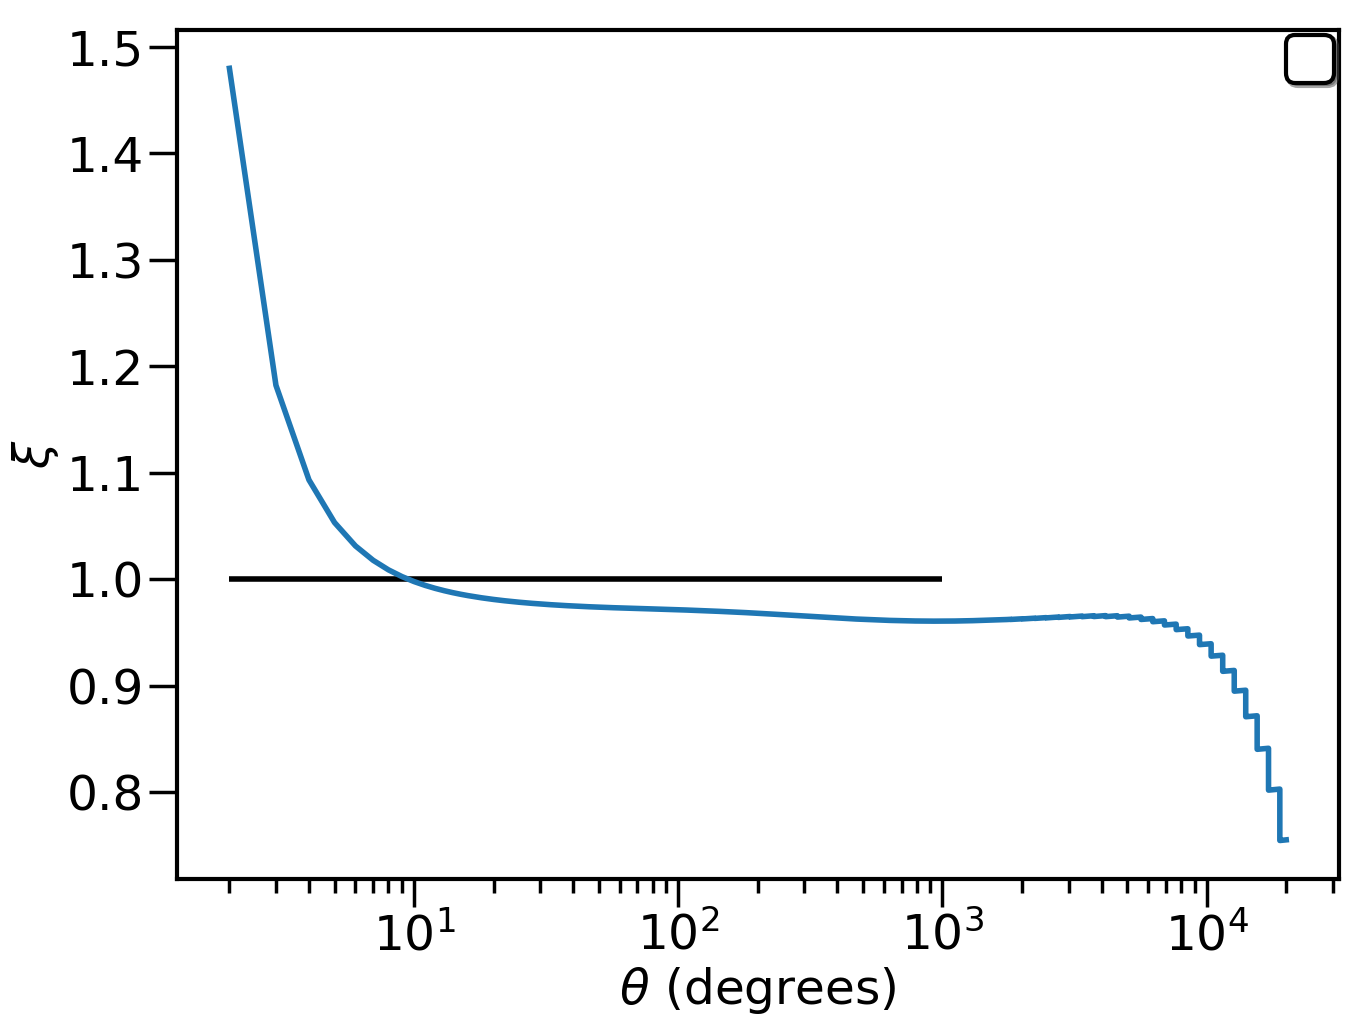

04:26:56 WARNING:No handles with labels found to put in legend.


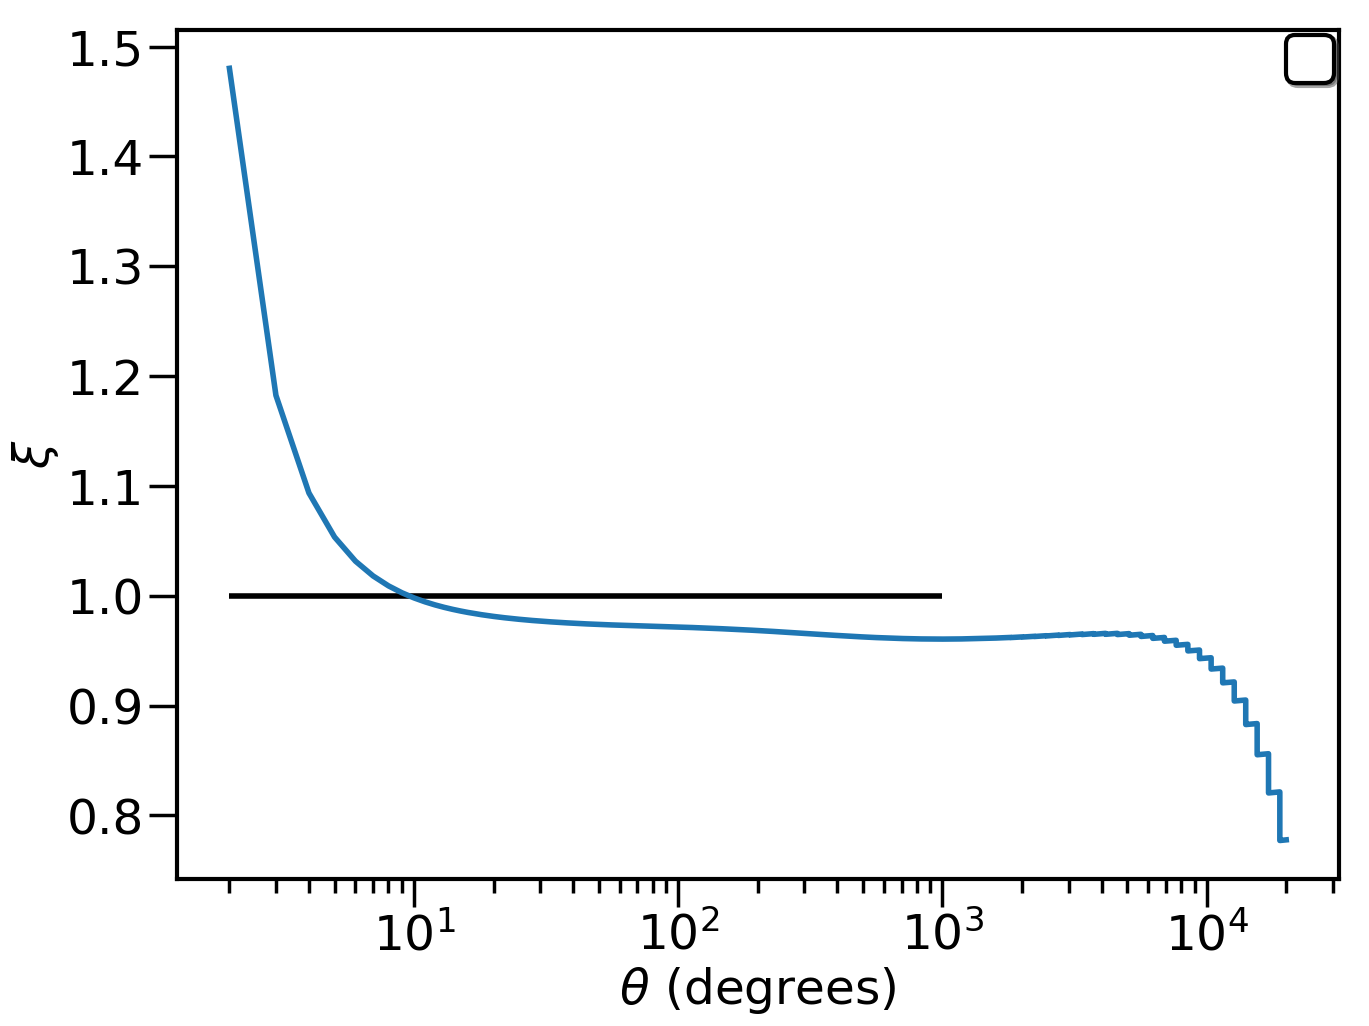

04:26:57 WARNING:No handles with labels found to put in legend.


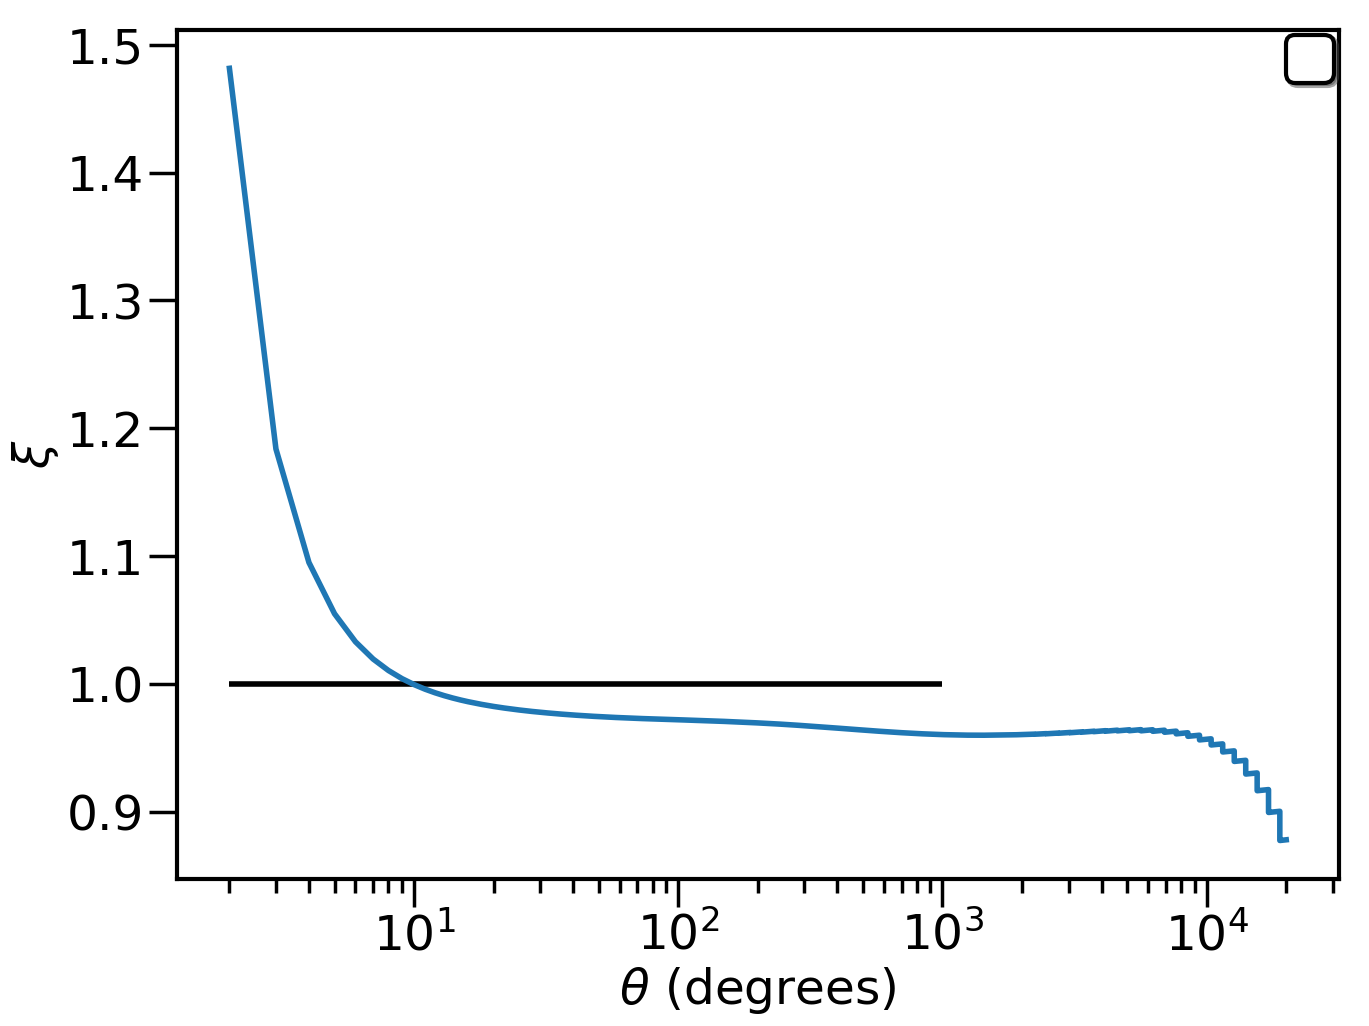

04:26:58 WARNING:No handles with labels found to put in legend.


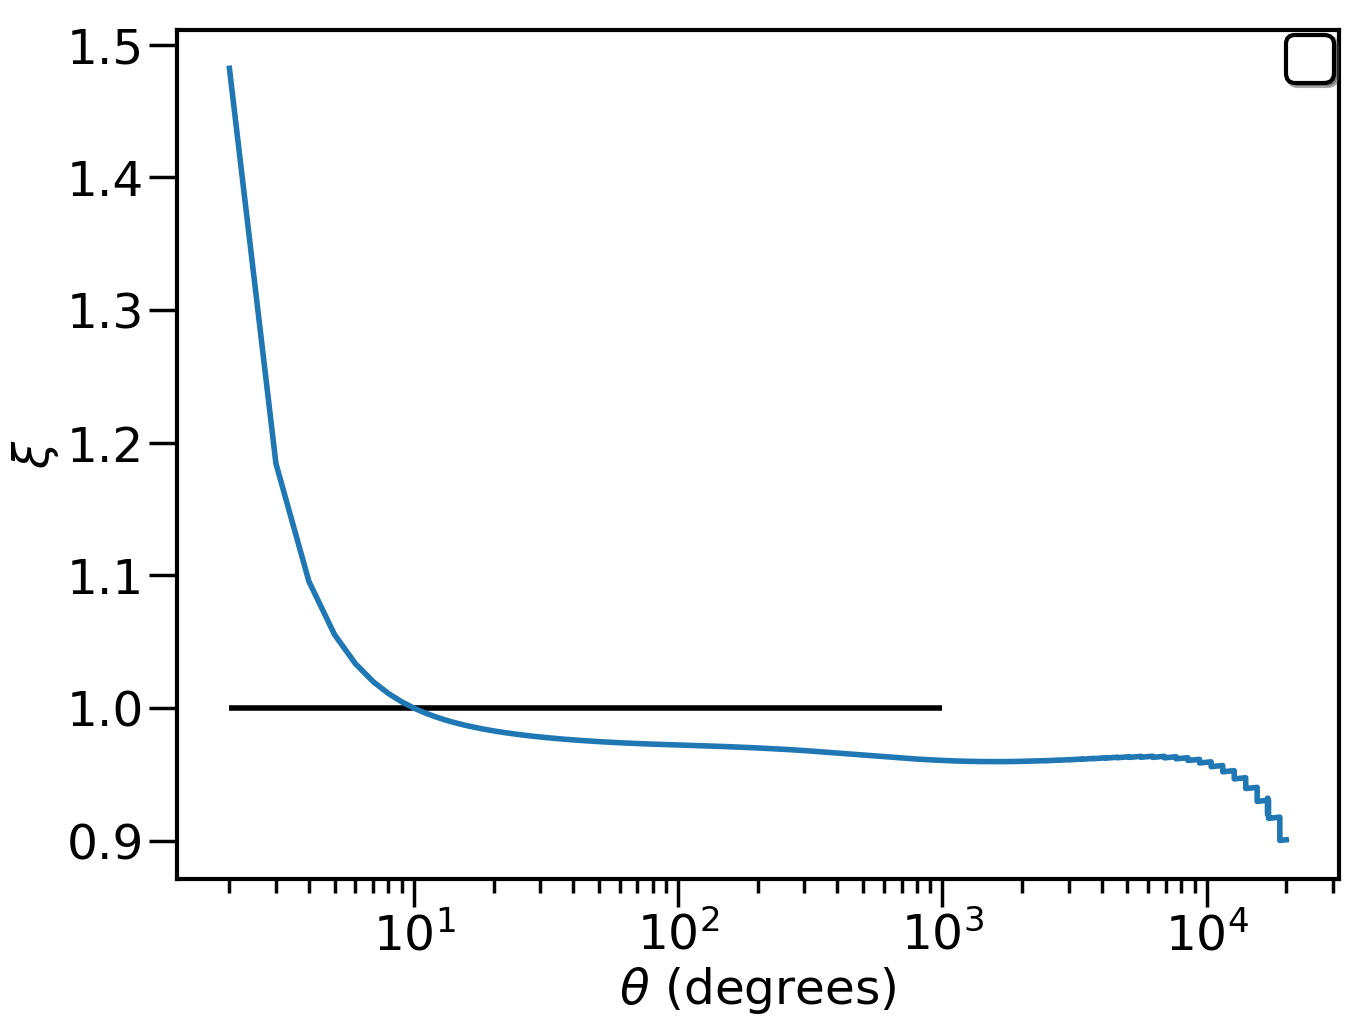

04:26:58 WARNING:No handles with labels found to put in legend.


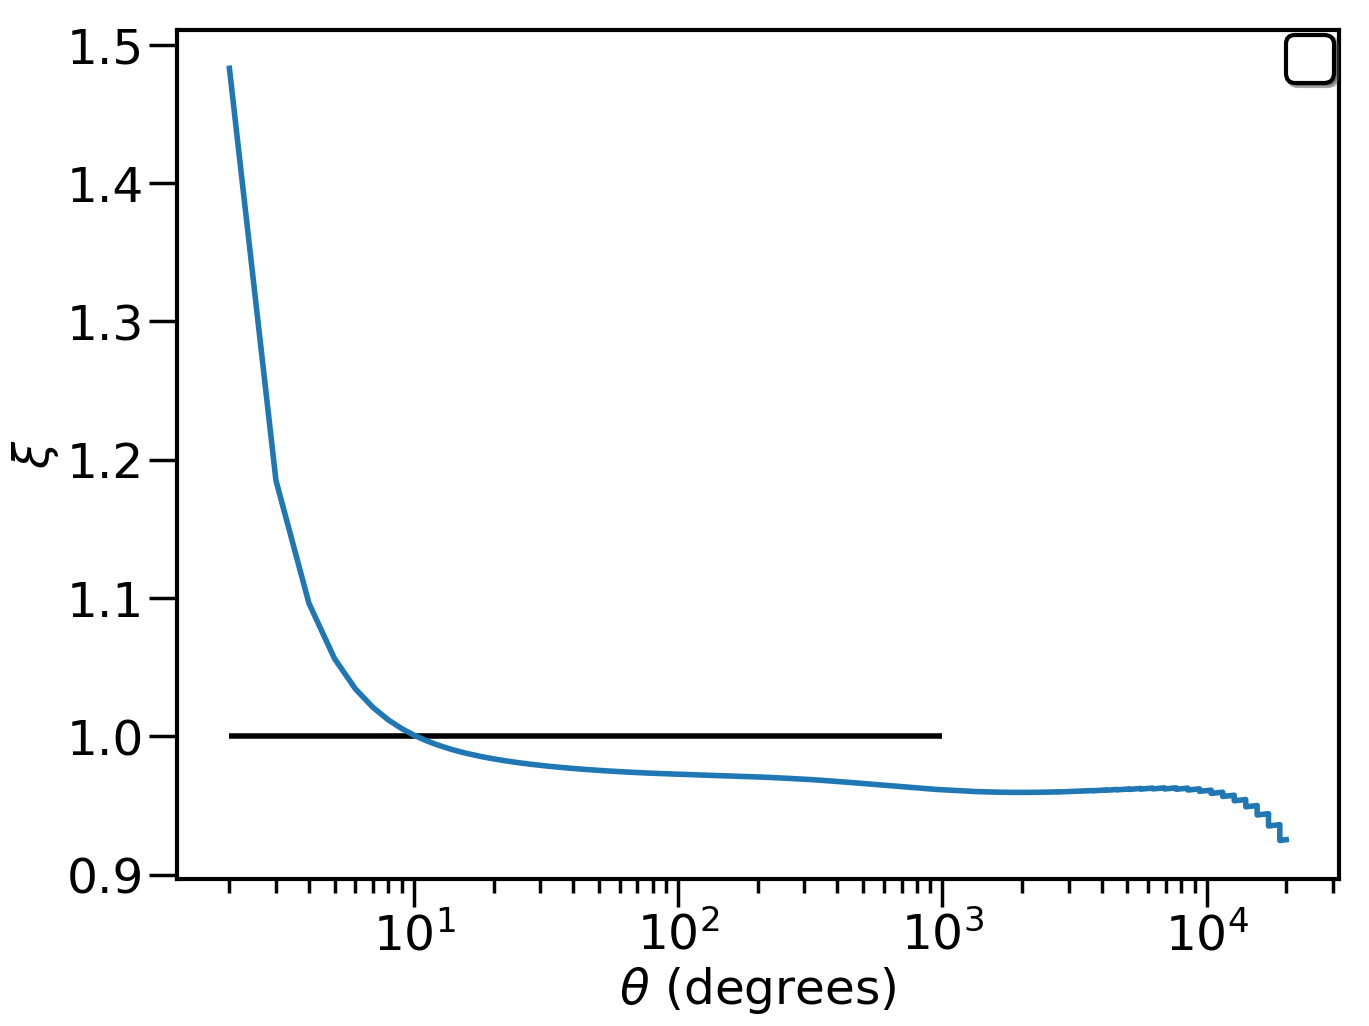

In [352]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
#         errorbar(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
#         plot(XI_W_L.l,xiWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
#         plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute(),marker='o',label=(i,j))
        lens1 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[i]['z'], n=zs_bins[i]['pz'])
        lens2 = ccl.ClTracerLensing(ccl_cosmo, False, z=zs_bins[j]['z'], n=zs_bins[j]['pz'])
        cls = ccl.angular_cl(ccl_cosmo, lens1, lens2, XI_W_L.l)
#         xi_plus = ccl.correlation(ccl_cosmo, ell, cls, th,corr_type='L+', method='FFTLog')
#         plot(XI_W_L.l,cls)
        plot(XI_W_L.l,clWG_L['cl'][corr][(i,j)].compute()/cls)
        xscale('log')
#         yscale('log')
        hlines(1,2,1000)
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
#         show()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


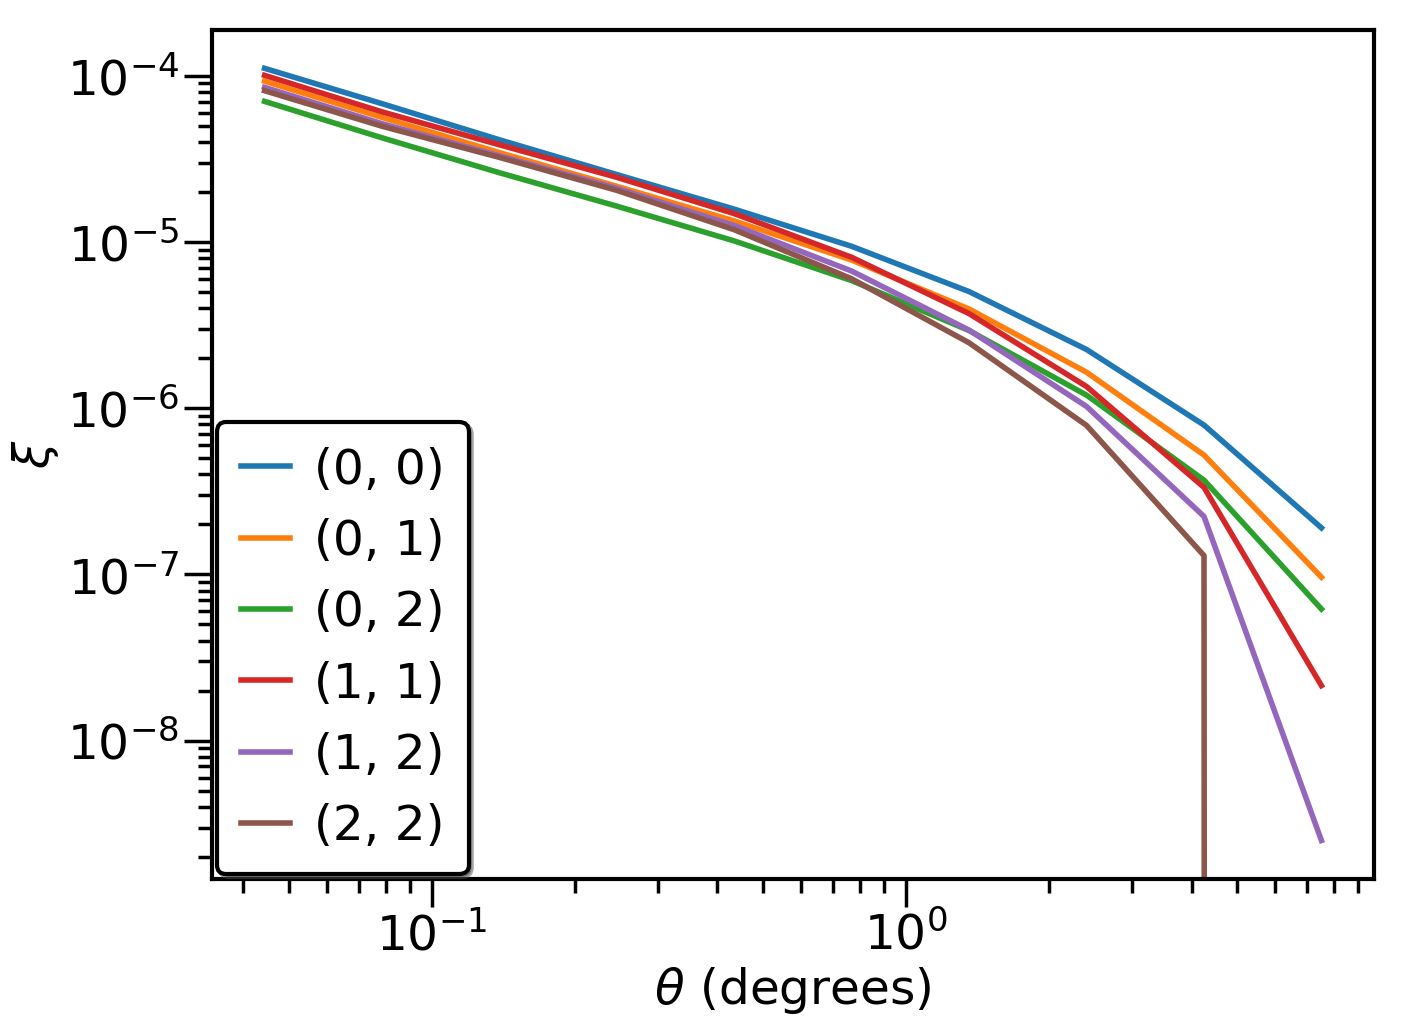

In [147]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


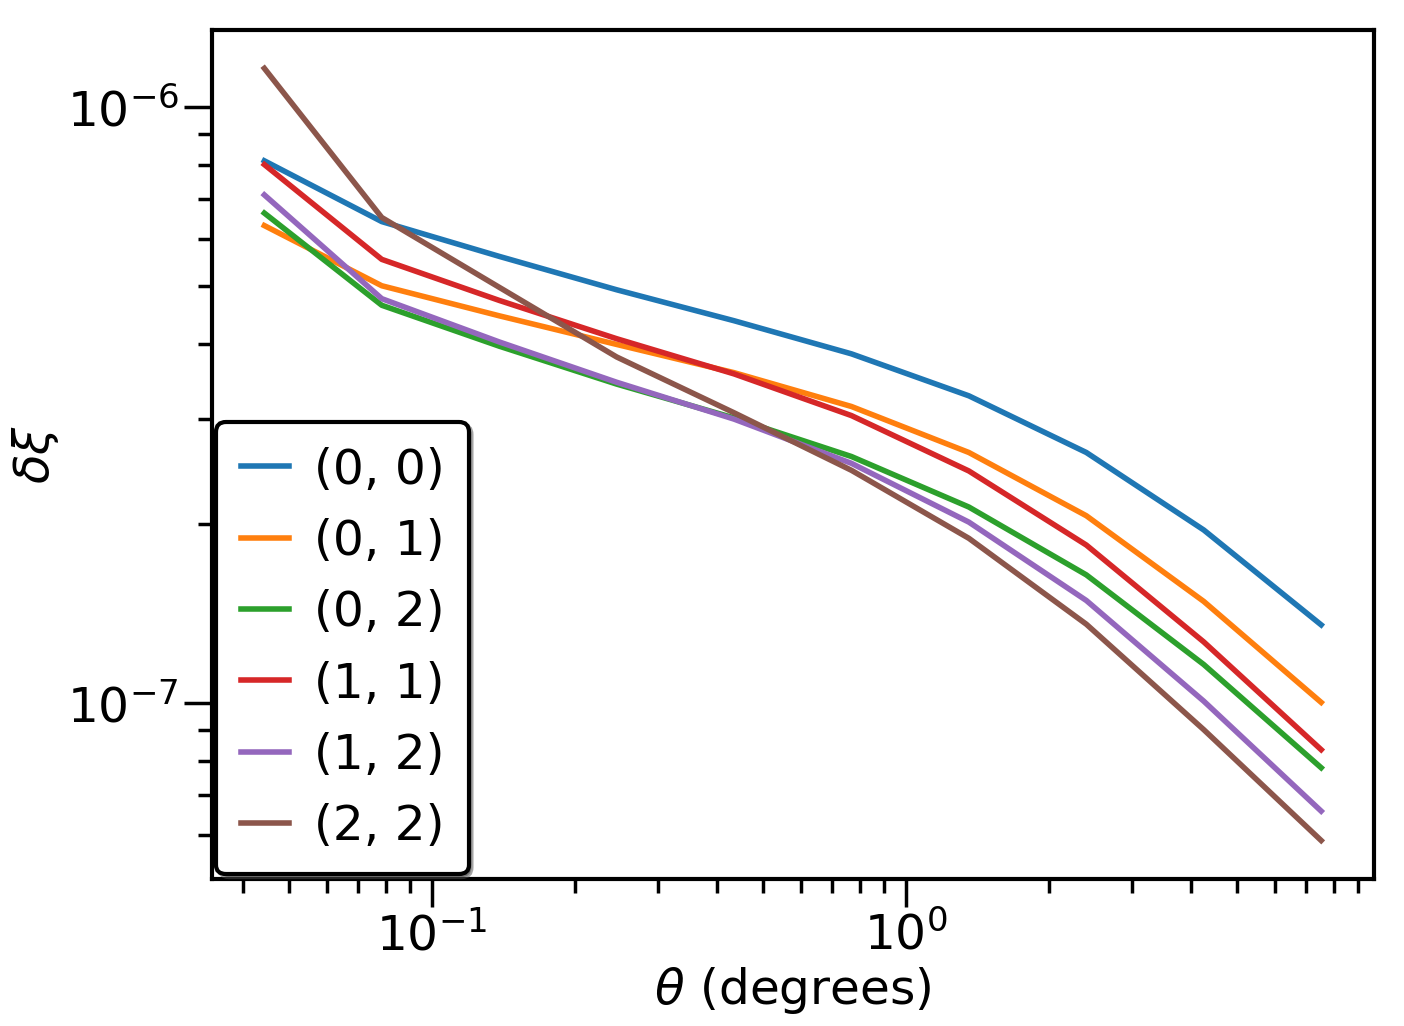

In [91]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb, np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta \xi $')
legend()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


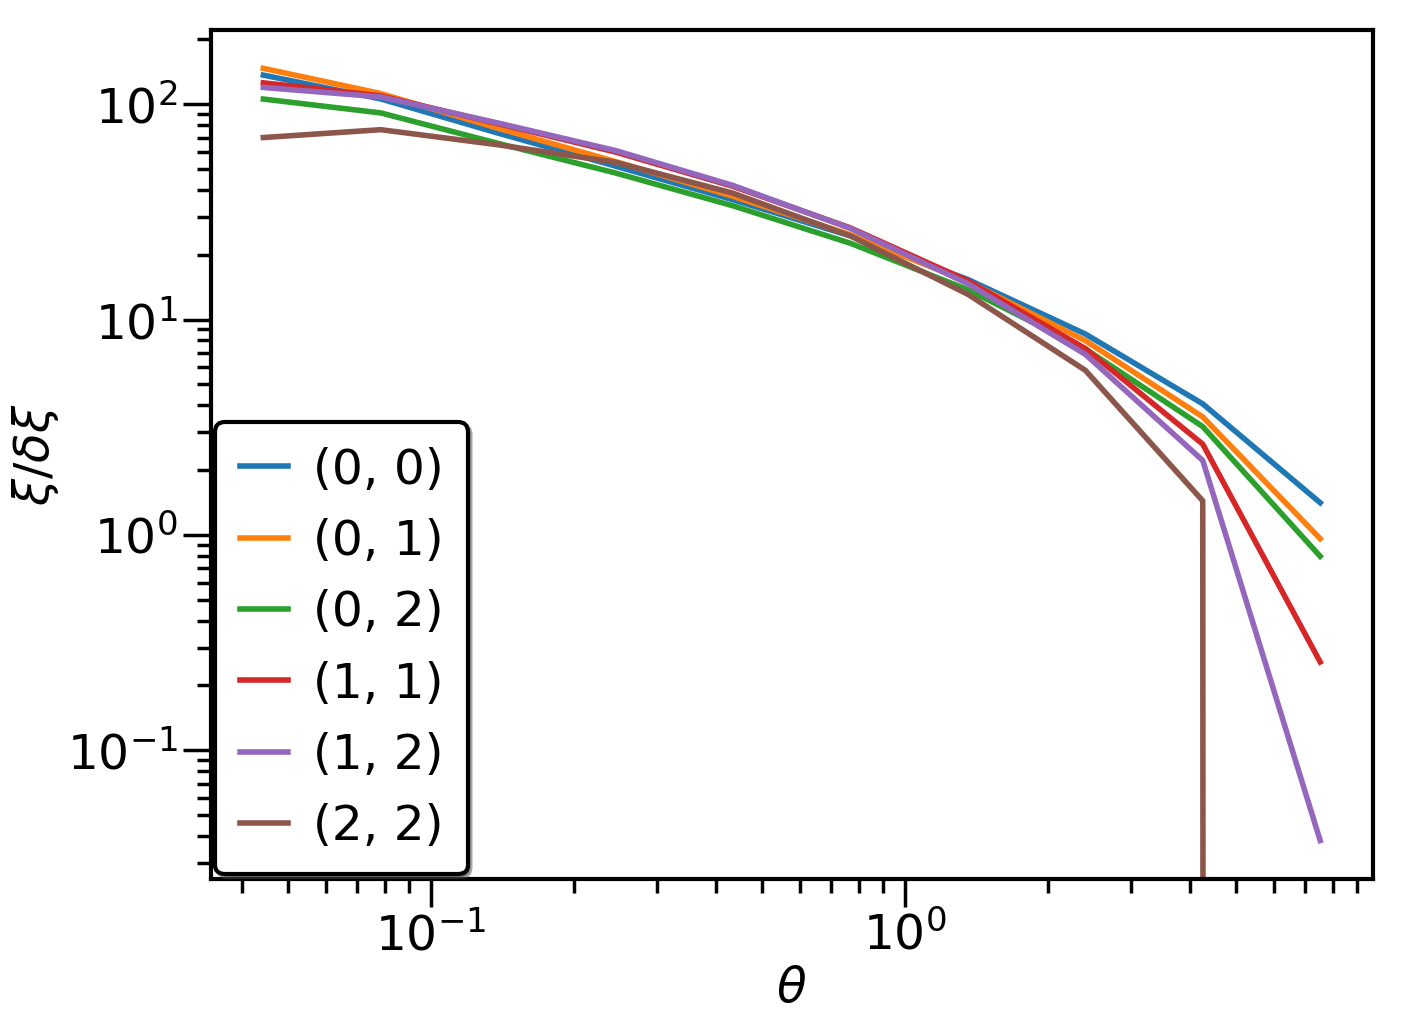

In [92]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiHG['xi'][corr][m1m2][(i,j)].compute()/np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$')
ylabel(r'$\xi/\delta \xi$')
legend()

In [93]:
nbins=3

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
06:52:53 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
06:52:53 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
06:52:53 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
06:52:53 DEBUG:findfont: Matching :family=STIXNonUnicode:style=no

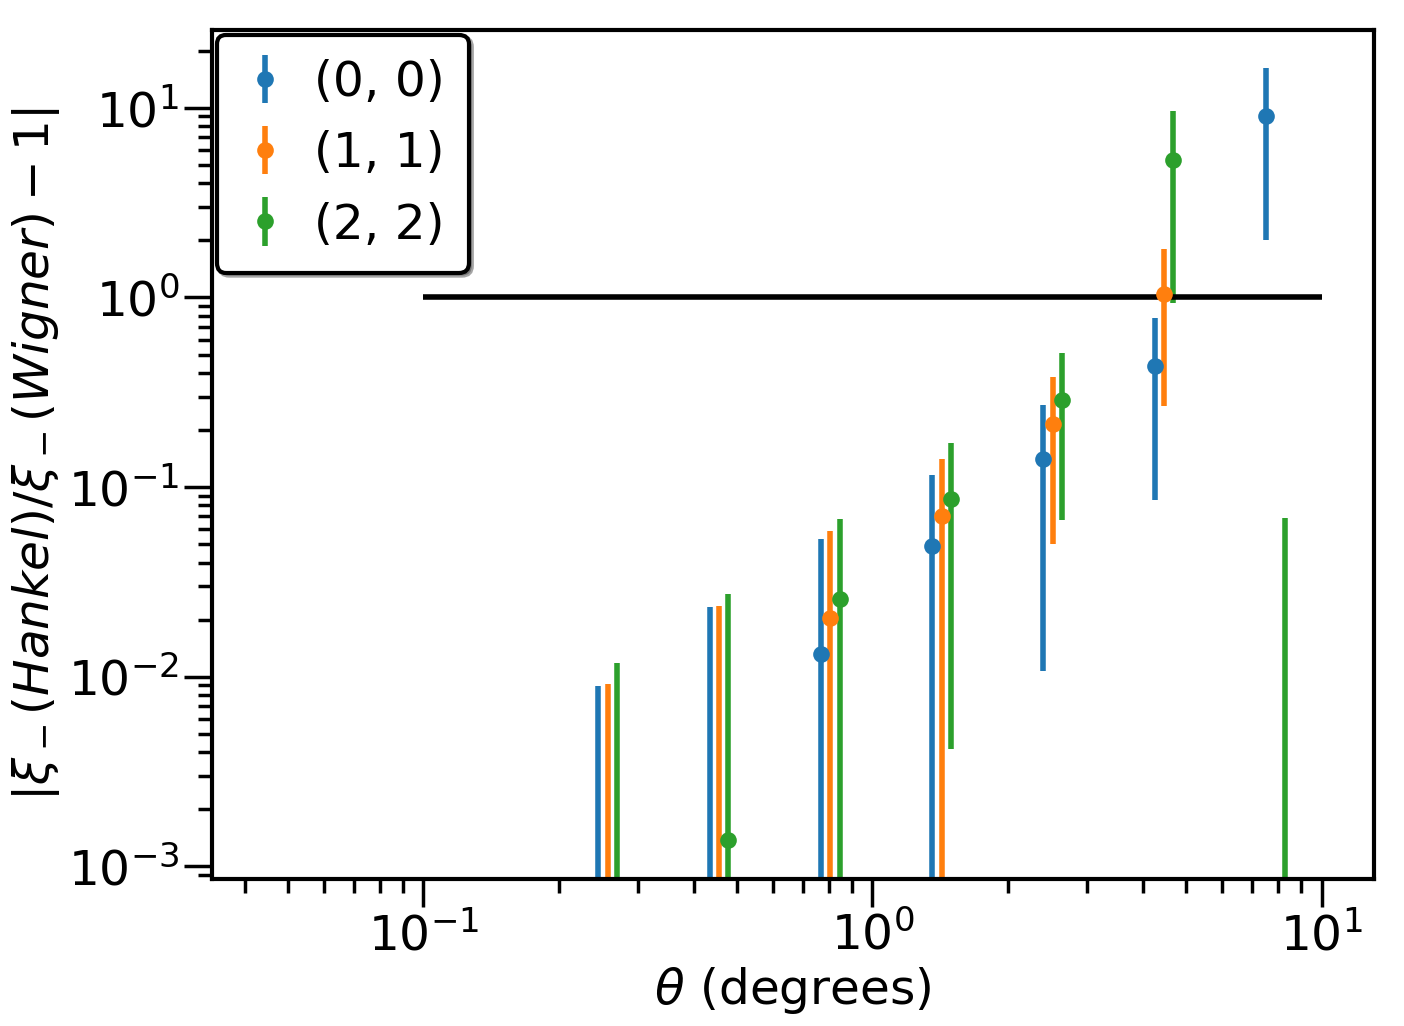

In [27]:
corr=('shear','shear')
m1m2=(2,2)
for i in np.arange(nbins):
    j=i
    errorbar(thb*(1+i*0.05),(xiHG['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute()-1),
                         np.sqrt(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/xiWG['xi'][corr][m1m2][(i,j)].compute(),
             fmt='o',label=(i,j)) 
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$|\xi_- ( {Hankel})/\xi_- ( {Wigner})-1|$')
hlines(1,0.1,10)
yscale('log')
legend()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


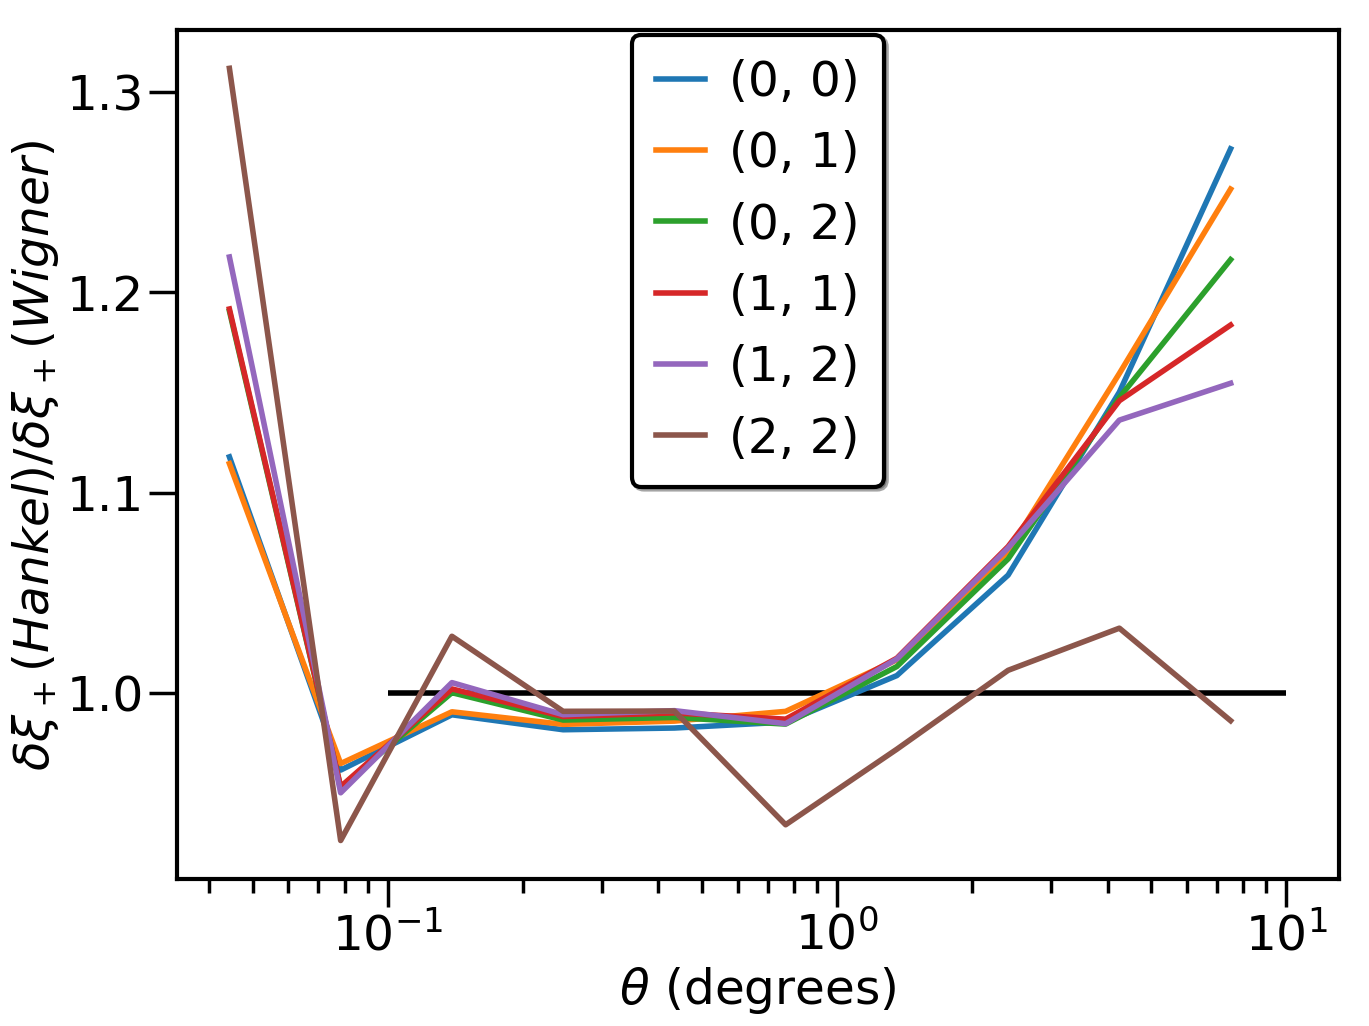

In [28]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,(np.diag(xiHG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi_+(Hankel)/\delta\xi_+(Wigner)$')
hlines(1,0.1,10)
legend()

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


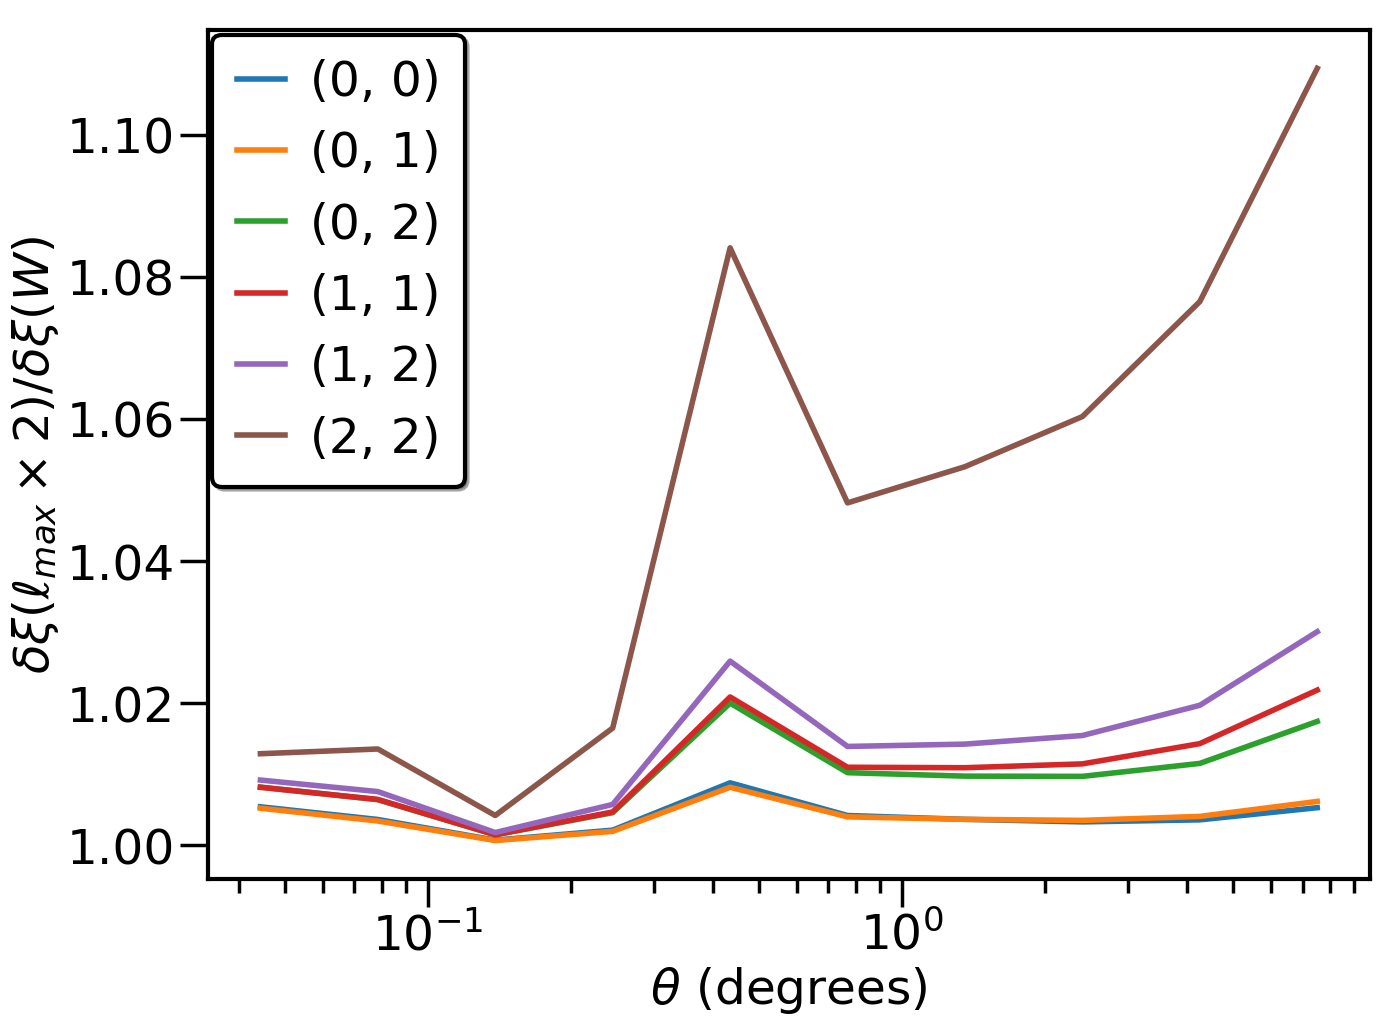

In [29]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,np.sqrt(np.diag(xiWG_L['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final']))/np.sqrt(np.diag(xiWG['cov'][corr+corr][m1m2+m1m2][(i,j,i,j)].compute()['final'])),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\delta\xi(\ell_{max}\times2)/\delta\xi(W)$')
# hlines(1,0.1,10)
legend()

In [30]:
m1m2

(2, 2)

/usr/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


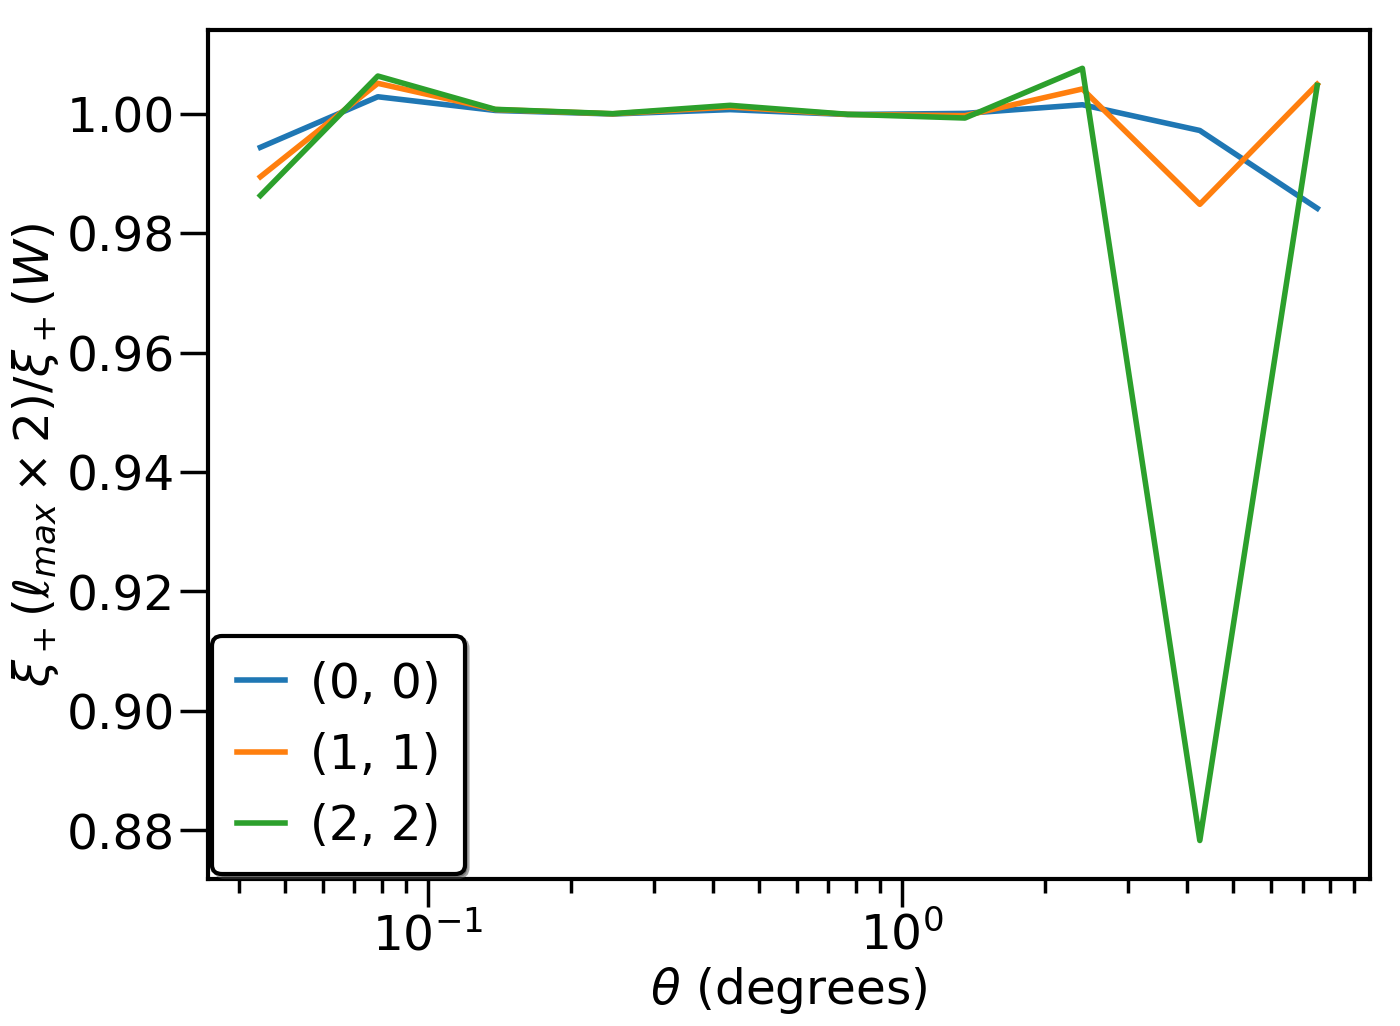

In [31]:
for i in np.arange(nbins):
    j=i
    plot(thb,xiWG_L['xi'][corr][m1m2][(i,j)].compute()/xiWG['xi'][corr][m1m2][(i,j)].compute(),label=(i,j))
xscale('log')
# yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi_+ (\ell_{max}\times2)/\xi_+ (W)$')
# hlines(1,0.1,10)
legend()

In [99]:
crash

NameError: name 'crash' is not defined

# Galaxy X Lensing Correlation function covariance

In [ ]:
import galaxy_utils
reload(galaxy_utils)
from galaxy_utils import *

In [ ]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [ ]:
#Setup redshift bins
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=5  # Number of tomographic bins
z_sigma=0.01
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
# nbins=3  # Number of tomographic bins
z_sigma=0.1
zg_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))


# nbins=np.int(nbins*(nbins+1.)/2.)
# zl_bins=lens_wt_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,z_bins=np.linspace(zmin,1.5,nbins),
#                           ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
#                         zp_sigma=z_sigma*np.ones_like(z))

SSV_cov=True
tidal_SSV=False

In [ ]:
do_xi=True
bin_xi=True
bin_cl=True
th_min=1./60
th_max=10
n_th_bins=20
n_th=160
th=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th)
th_bins=np.logspace(np.log10(th_min*2),np.log10(th_max),n_th_bins+1)
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [ ]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [ ]:
# Wigner Transform setup
l_W=np.arange(2,l_max,dtype='int')
WT_kwargs={'l':l_W ,'theta':th*d2r ,'m1_m2':[(0,0),(0,2),(2,2),(2,-2)]}
# %time WTggl=wigner_transform(**WT_kwargs)

XI_W= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zg_bins,
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=do_xi,HT=WTggl,
#               HT_kwargs=HT_kwargs,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

In [ ]:
%time cl_Wggl=XI_W.cl_tomo(corrs=[corr_ll,corr_ggl,corr_gg])

In [ ]:
%time xiWggl=XI_W.xi_tomo(corrs=[corr_ll,corr_ggl,corr_gg])
%time xiW_ggl=xiWggl['stack'].compute()

In [ ]:
cl_Wggl['cl'][corr_ggl][(0,0)].compute().min()

In [ ]:
cl_Wggl['cl'].keys()

In [ ]:
cl_Wggl['cov'][corr_ggl+corr_ggl][(0,0,0,1)]['G1423'].compute().min()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        plot(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),label=(i,j))
        plot(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),ls='--')
        xscale('log')
        yscale('log')
        xlabel(r'$\theta$ (degrees)')
        ylabel(r'$\xi$')
        legend()
show()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(0,nbins):
        errorbar(thb,xiWggl['xi'][corr_ggl][m1m2][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
for i in np.arange(nbins):
    for j in np.arange(i,nbins):
        errorbar(thb,xiWggl['xi'][corr_gg][m1m2_gg][(i,j)].compute(),np.sqrt(np.diag(xiWggl['cov'][corr_ggl+corr_ggl][m1m2+m1m2][(i,j,i,j)].compute()['final'])),fmt='o',label=(i,j))
xscale('log')
yscale('log')
xlabel(r'$\theta$ (degrees)')
ylabel(r'$\xi$')
legend()

In [ ]:
nbins=5

In [ ]:
cc=XI_W.cov_utils
corrW=cc.corr_matrix(xiW_ggl['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
x1=20.*nbins*(nbins+1)/2.
x2=20.*nbins*nbins
hlines(x1,0,len(corrW),lw=2)
vlines(x1,0,len(corrW),lw=2)
hlines(x1*2,0,len(corrW),lw=2)
vlines(x1*2,0,len(corrW),lw=2)
hlines(x1*2+x2,0,len(corrW),lw=2)
vlines(x1*2+x2,0,len(corrW),lw=2)
title('Wigner')
xticks([])
yticks([])
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [ ]:
import healpy as hp
hp.nside2npix(1024)